# Auto Encoders and Variational Auto Encoders on MNIST

In this notebook we are going to demonstrate Auto Encoder and Variational Auto Encoder models on MNIST data.  

We will go through many visualizations to develop good intuition on how these models work.

### Set GPU for Runtime

<p id="7ecb" class="gy gz ef at ha b hb ja hd jb hf jc hh jd hj je hl" data-selectable-paragraph="">It is so simple to alter default hardware <strong class="ha hm">(CPU to GPU or vice versa)</strong>; just follow <strong class="ha hm">Edit &gt; Notebook settings</strong> or <strong class="ha hm">Runtime&gt;Change runtime type </strong>and <strong class="ha hm">select GPU </strong>as <strong class="ha hm">Hardware accelerator</strong>.</p>

![tittle](https://miro.medium.com/max/740/1*WNovJnpGMOys8Rv7YIsZzA.png)

### Imports

In [2]:
# Python lib
import os
from typing import List, Tuple

# Scientific utilities
import numpy as np
import pandas as pd
from scipy.stats import norm as ndist

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.optim as optim

# Vizualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Set Device

If you have correctly chosen GPU device then you will have device=="cuda"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cuda')

### Globals

In [4]:
DATA_DIR = 'data'

BATCH_SIZE = 128

### Preparing Data

Conveniently, PyTorch comes with pre-defined MNIST dataset so we are going to use it directly.

In [5]:
def get_mnist_ds(train: bool):

    return torchvision.datasets.MNIST(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                ]), 
                                      target_transform=None, 
                                      download=True)

def get_mnist_dls():
    
    train_ds = get_mnist_ds(train=True)
    valid_ds = get_mnist_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=False))

train_dl, valid_dl = get_mnist_dls()

len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

### Show samples from Training Data

In [6]:
def show(img:torch.Tensor, title=None, figsize=(15, 15)):
    np_img = img.permute(1,2,0).numpy()
    plt.figure(figsize=figsize)
    fig = plt.imshow(np_img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.show()

In [7]:
def show_batch(batch, samples=None, title=None, figsize=(15, 15)):
    if not samples:
        samples = batch.shape[0]
    
    sample_batch = batch[:samples, :, :]
    batch_grid = make_grid(sample_batch)
    show(batch_grid, title, figsize)

torch.Size([128, 1, 28, 28]) tensor(0.1323) tensor(0.3104) tensor(0.) tensor(1.)


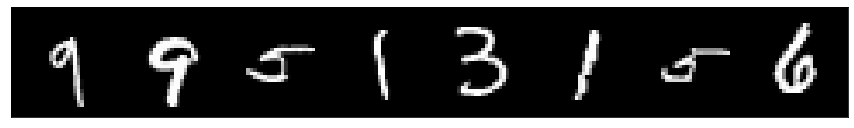

torch.Size([128, 1, 28, 28]) tensor(0.1261) tensor(0.3034) tensor(0.) tensor(1.)


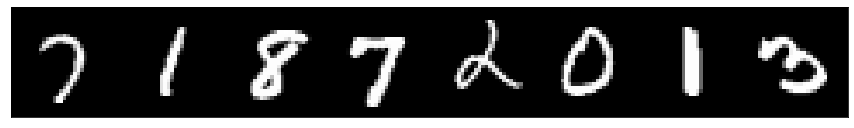

torch.Size([128, 1, 28, 28]) tensor(0.1301) tensor(0.3064) tensor(0.) tensor(1.)


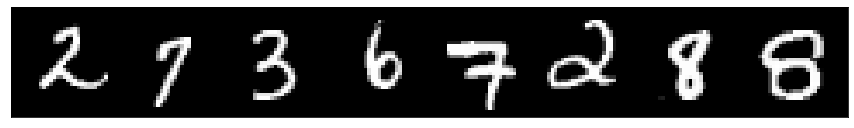

torch.Size([128, 1, 28, 28]) tensor(0.1344) tensor(0.3118) tensor(0.) tensor(1.)


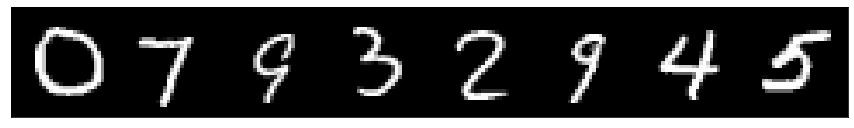

In [8]:
# displaying some of the images with some stats. 

for i, (x, y) in enumerate(train_dl):
    print(x.shape, x.mean(), x.std(), x.min(), x.max())
    show_batch(x, samples=8)
    if i > 2: break

## Training Vector Quantized Variational Auto Encoder (VQ-VAE)

In [9]:
# this is helper function for initializing weights of the model.

def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            nn.init.constant_(m.bias, 0)

We fill be using simle encoder with one hidden layer and Relu activation

In [10]:
class Encoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_shape), hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, out_dim))
        
        init_weights(self)
        
    def forward(self, x): return self.enc(x)

In [11]:
enc = Encoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
enc

Encoder(
  (enc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
  )
)

In [12]:
class Decoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.inp_shape = inp_shape
        
        self.dec = nn.Sequential(nn.Linear(out_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, np.prod(inp_shape)))
        
        init_weights(self)
        
    def forward(self, x): return torch.sigmoid(self.dec(x)).view(x.shape[0], *self.inp_shape)

In [13]:
dec = Decoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
dec

Decoder(
  (dec): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [14]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings:int, embedding_dim:int, commitment_cost:float):
        """
        Args:
            num_embeddings: number of embeddings to have in Quantizer CodeBook 
            embedding_dim: dimension of embedding vectors
            commitment_cost: coefficient of cost for latent vectors (from encoder)
        """
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        
        # initialize embedding with continuous uniform distribution with P(x)=1/(-1/n_emb - 1/n_emb) 
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        
    def forward(self, inputs):
        """
        Args:
            inputs: latent vectors which are outputs of encoder 
        Returns:
            (Tensor, Tensor, Tensor, Tensor): Calculated loss, quantized vectors,  Calculated perplexity and encodings
        """
                # convert inputs from BCHW -> BHWC
        # We are going to use Channel dimension to quantize image features which were encoded by Encoder network
        inputs = inputs.contiguous() 
        
        # Flatten input to get (B*H*W)C
        # We get (B*H*W) vectors of dimension C.
        # If we have B=1 (one image only) we have (H*W) number of vectors of C dimension.
        # (H*W) number of vectors can become (H*W) discrete features and will explain our 
        # image (face attributes/features) but we don't have guarantee that quantized vectors in codebook
        # correspond to disentangled features of image easily interpretable for human (like: Eyeglasses, 
        # GrayHair, Mustache, NarrowEyes, etc).
        # Quantized vectors are latent features which are combinations of many features together.
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # We have embedding matrix of KD dimension (K == number of vectors,  D == vector's dimension)
        # Here we are calculating euclidean distance between (B*H*W) number of C dimensional vectors and 
        # K number of D dimensional codebook vectors. (Notice that dimension of image channels and dimension of 
        # codebook vectors are equal (C==D))
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Here we find indices of closest vectors of codebook vectors for each image vectors
        # Here torch.scatter function converts found indices to one-hot vectors and 
        # we get matrix of dimension (B*H*W)K where element of i-th row and j-th column is 1 if 
        # i-th vector's (from image latent vectors) closest to j-th vector from codebook 
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Now we just multiply matrix of one-hot encodings to codebook matrix to get quantized vectors 
        # So we multiply matrix of one-hot vectors of shape (B*H*W)K to matrix of KD and we get
        # quantized vectors matrix of shape (B*H*W)D or (B*H*W)C (because C==D)
        # Intuitively we just replaced latent features from encoder with closest latent features 
        # from our codebook which is well known for decoder.
        quantized = torch.matmul(encodings, self._embedding.weight).view(inputs.shape)
        
        # As our reconstructions fully depend on codebook latent vectors, we need to use them efficiently
        # and encode as much information as possible to give best feature descriptions to decoder which will
        # try to reconstruct the original image. 
        
        # 1) To achieve this we need to have feature vectors generated by encoder network as close as possible
        # to our codebook vectors. This is done by `EncoderLatentLoss` minimization. We are actually 
        # bringing encoder latent vectors close to codebook vectors. (Here you see that quantized 
        # vectors are detached to stop gradient computation for them and only optimize encoder latents)
        
        # 2) Also we need to optimize usage of quantized codebook vectors to compress the information as much  
        # as possible and generate broad latent vectors covering many features of images. 
        # This is done by `QuantizedLatentLoss` minimization. We are actually 
        # bringing codebook latent vectors close to encoder latent vectors. (Here you see that encoder latent vectors
        # are detached to stop gradient computation for them and only optimize quantized codebook latents vectors)
        
        # Loss = commitment_cost * ||sg[q]-e|| + ||q-sg[e]||  (sg - STOP_GRADIENT operation)
        # Commitment cost is coefficient for encoder latent loss which is (0, 1) range 
        # (commitment_cost=0.25 is recommended from author)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        # Trick used here is for gradient copying from decoder to encoder without touching quantization part
        quantized = inputs + (quantized - inputs).detach()
        
        # Here we calculate average usage of each quantized vector in quantization (how many times each codebook 
        # latent vector was assigned to encoder latent vectors)
        avg_probs = torch.mean(encodings, dim=0)
        
        # We calculate perplexity of codebook usage which will be used later for loss calculation in training loop
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized vectors from BHWC -> BCHW to pass to decoder
        return loss, quantized.contiguous(), perplexity, encodings

In [15]:
vq = VectorQuantizer(num_embeddings=10, embedding_dim=256, commitment_cost=0.25)

In [16]:
vq

VectorQuantizer(
  (_embedding): Embedding(10, 256)
)

In [17]:
class VectorQuantizedVariationalAutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int, num_embeddings:int, commitment_cost: float):
        super().__init__()
        
        self.enc = Encoder(inp_shape, hidden_dim, out_dim)
        self.dec = Decoder(inp_shape, hidden_dim, out_dim)
        
        self.vq = VectorQuantizer(num_embeddings, out_dim, commitment_cost)
        
        init_weights(self)
        
    def encode(self, x):
        
        return self.enc(x)
        
    def decode(self, z):
        
        return self.dec(z)
        
    def forward(self, x):
        z = self.encode(x)
        loss, qnt, perp, _ = self.vq(z)
        x_recon = self.dec(qnt)
        
        return loss, x_recon, perp

In [18]:
def train_vq_vae(train_dl: DataLoader, model: nn.Module, num_training_updates, learning_rate, 
                ):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
    model.to(device)
    model.train()

    train_res_recon_error = []
    train_res_perplexity = []

    for i in range(num_training_updates):
        data, labels = next(iter(train_dl))
        data = data.to(device)

        # zero gradients
        optimizer.zero_grad()

        # forward pass to calculate vector quantizer loss, reconstructions and perplexity
        vq_loss, data_recon, perplexity = model(data)

        # calculate reconstruction erros for given batch (divided by calculated data variance)
        recon_error = F.mse_loss(data_recon, data) / DATASET_VARIANCE

        # calculate full loss (reconstruction loss + vector quantizer loss)
        loss = recon_error + vq_loss

        # backward pass to update weights
        loss.backward()
        optimizer.step()

        # save reconstruction error and perplexity values
        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        # show original reconstructions and images for every n-th iteration on batches 
        if (i+1) % SHOW_EVERY_N_ITERATION == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-SHOW_EVERY_N_ITERATION:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-SHOW_EVERY_N_ITERATION:]))
            print()

            show_batch(data_recon.cpu().detach(), samples=8, title=f'Reconstructions After {i+1} Iterations')
            show_batch(data.cpu().detach(), samples=8, title=f'Original Images')


In [ ]:
num_training_updates = 15000
commitment_cost = 1.0
learning_rate = 1e-3
RELU_NEG_SLOPE = 0.2
SHOW_EVERY_N_ITERATION = 100

# default variance not calculated on given data.
DATASET_VARIANCE = 1.0

In [37]:
vq_vae = VectorQuantizedVariationalAutoEncoder(
        inp_shape=(1, 28, 28), 
        hidden_dim=512, 
        out_dim=256, 
        num_embeddings=32, 
        commitment_cost=1.0
)
vq_vae

VectorQuantizedVariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (vq): VectorQuantizer(
    (_embedding): Embedding(32, 256)
  )
)

100 iterations
recon_error: 0.099
perplexity: 2.802



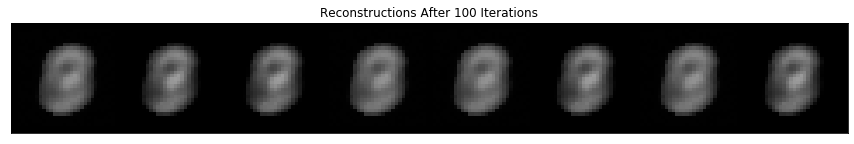

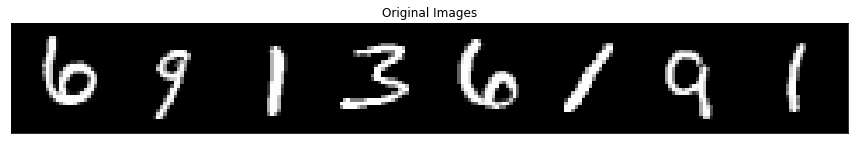

200 iterations
recon_error: 0.065
perplexity: 2.885



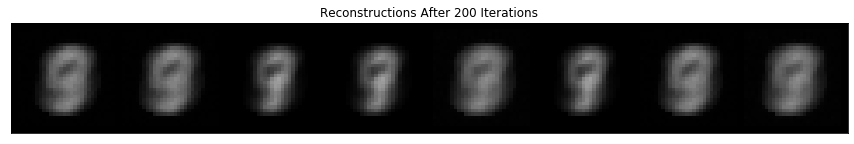

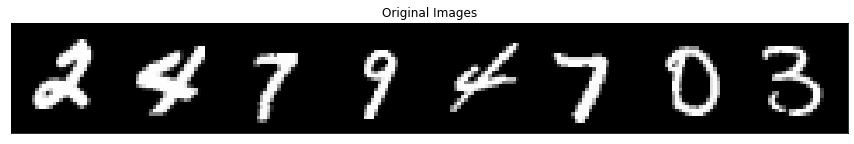

300 iterations
recon_error: 0.061
perplexity: 4.632



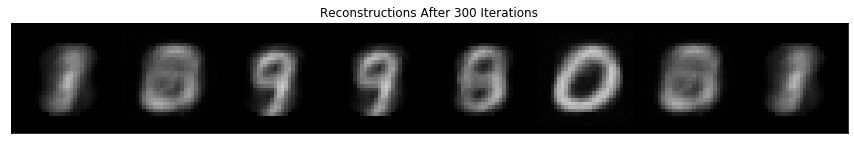

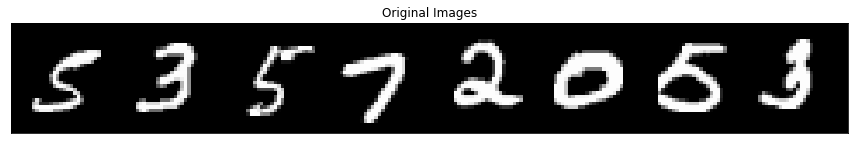

400 iterations
recon_error: 0.058
perplexity: 7.067



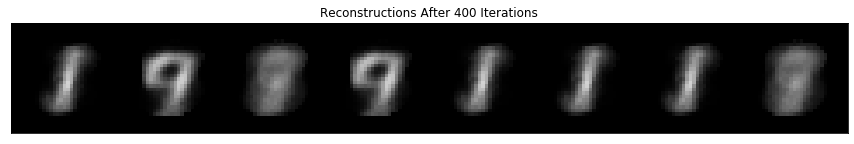

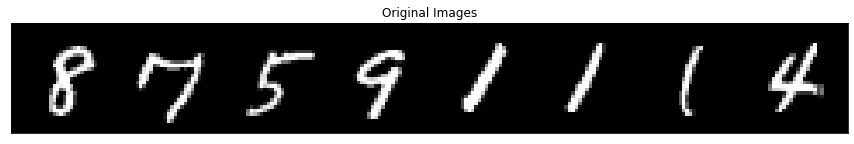

500 iterations
recon_error: 0.055
perplexity: 7.882



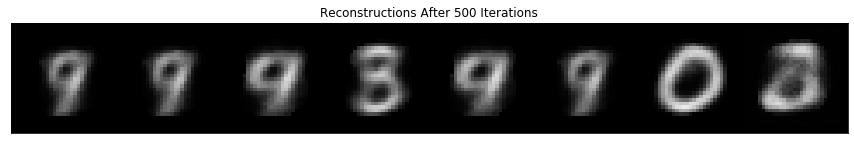

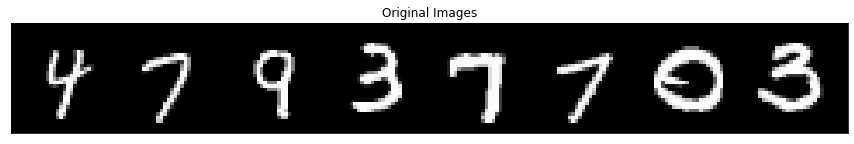

600 iterations
recon_error: 0.053
perplexity: 9.587



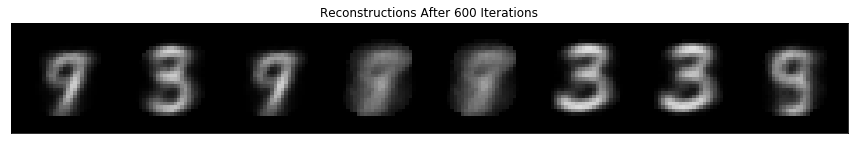

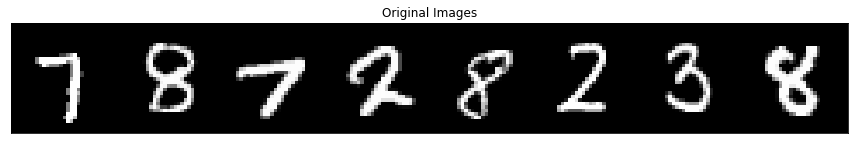

700 iterations
recon_error: 0.052
perplexity: 11.581



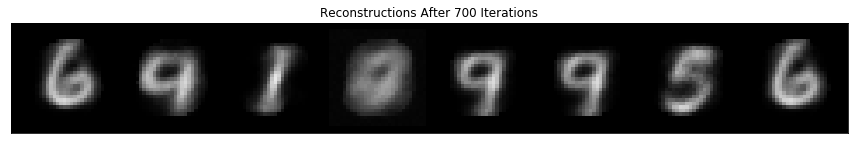

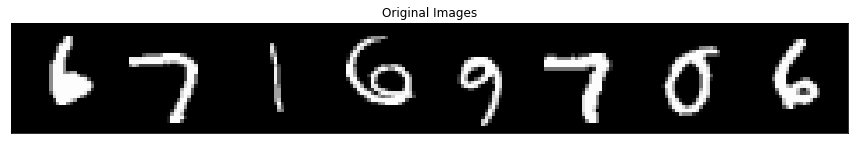

800 iterations
recon_error: 0.051
perplexity: 13.046



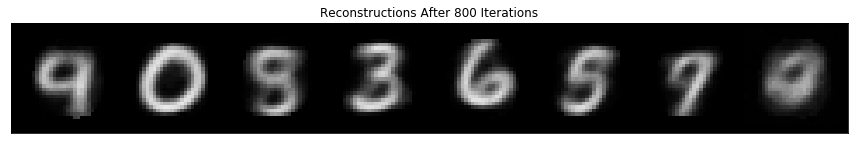

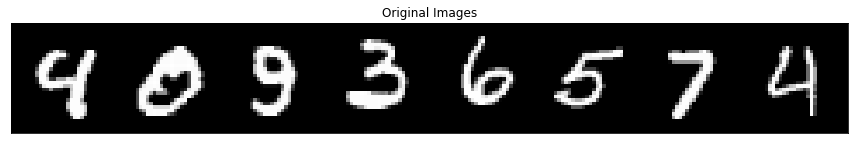

900 iterations
recon_error: 0.049
perplexity: 14.500



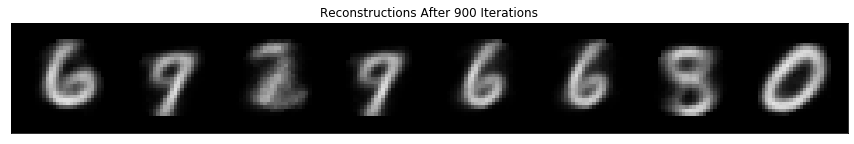

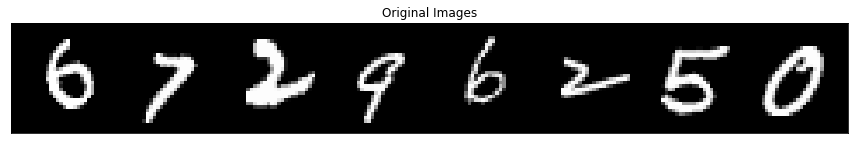

1000 iterations
recon_error: 0.048
perplexity: 15.703



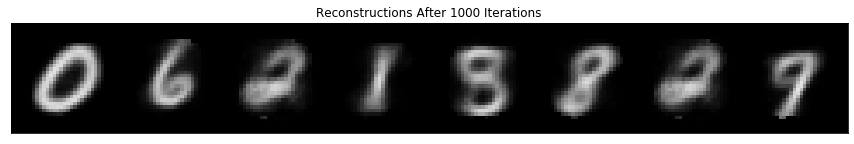

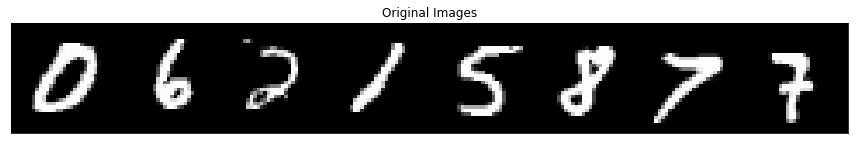

1100 iterations
recon_error: 0.048
perplexity: 16.918



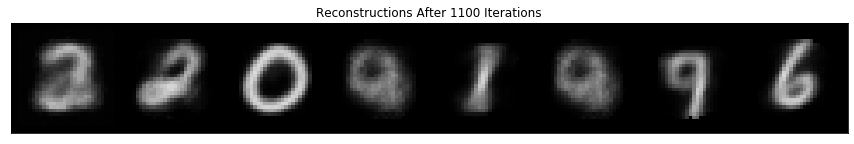

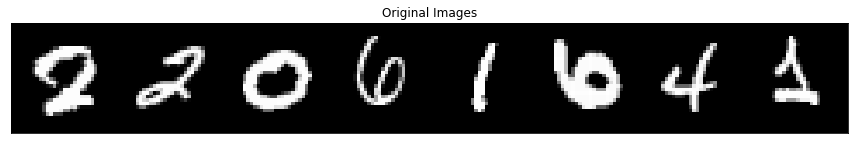

1200 iterations
recon_error: 0.047
perplexity: 17.855



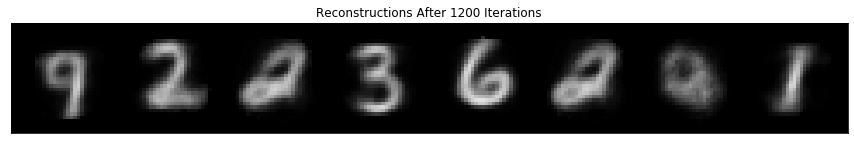

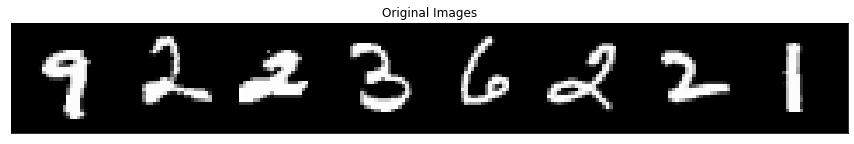

1300 iterations
recon_error: 0.047
perplexity: 18.531



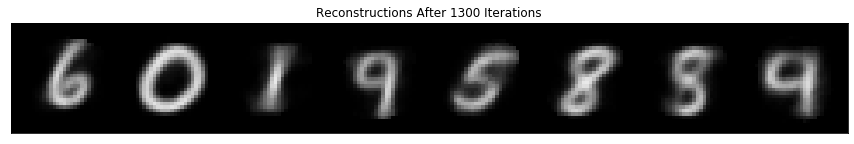

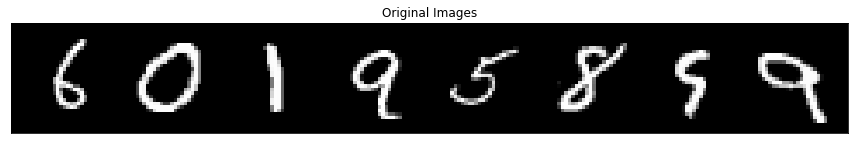

1400 iterations
recon_error: 0.047
perplexity: 18.934



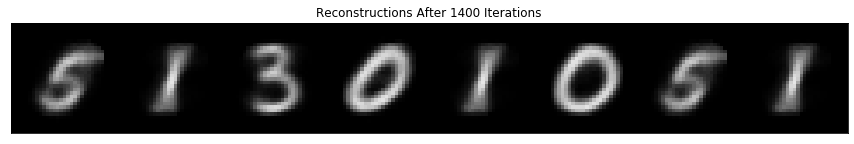

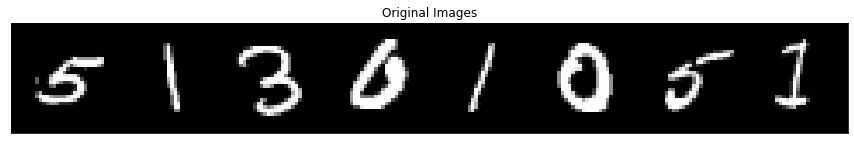

1500 iterations
recon_error: 0.046
perplexity: 19.734



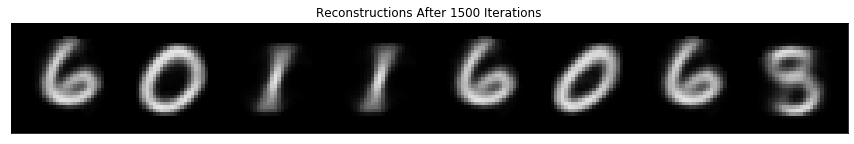

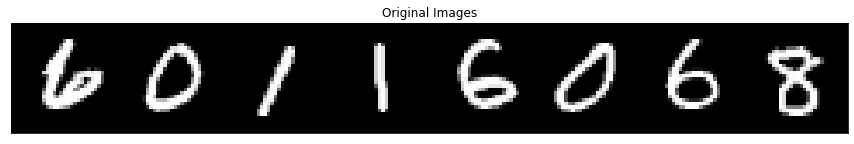

1600 iterations
recon_error: 0.046
perplexity: 21.215



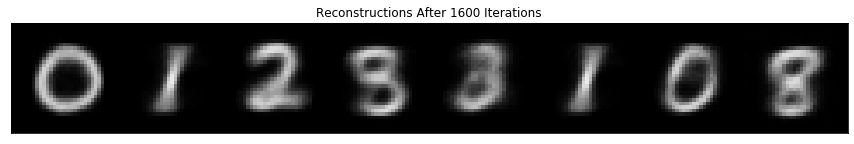

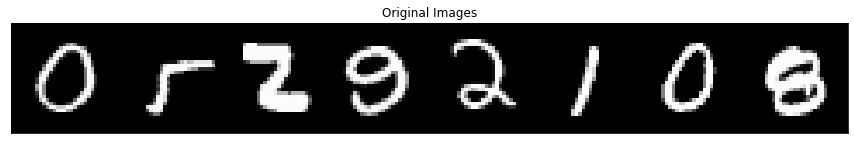

1700 iterations
recon_error: 0.045
perplexity: 21.664



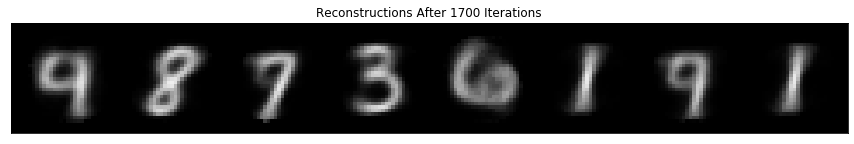

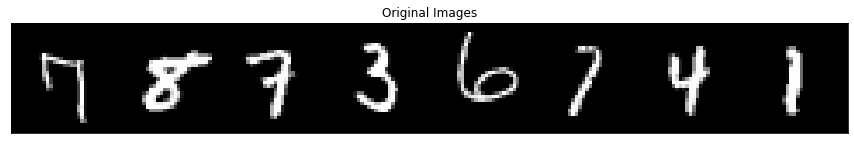

1800 iterations
recon_error: 0.045
perplexity: 22.551



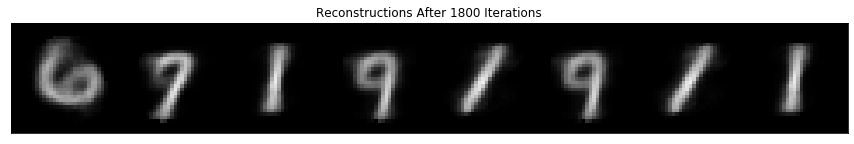

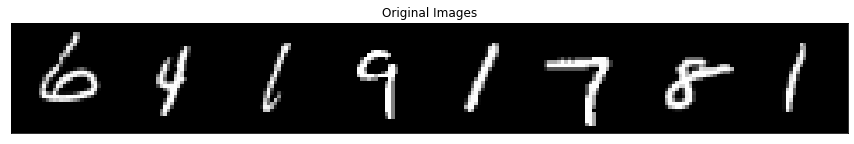

1900 iterations
recon_error: 0.044
perplexity: 23.342



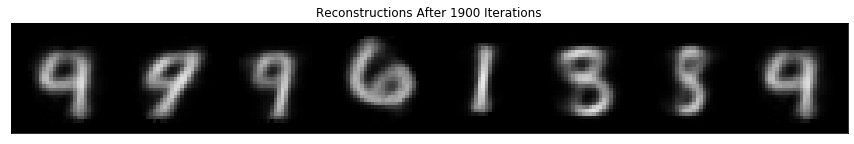

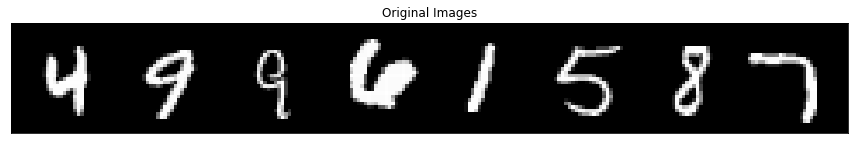

2000 iterations
recon_error: 0.044
perplexity: 24.016



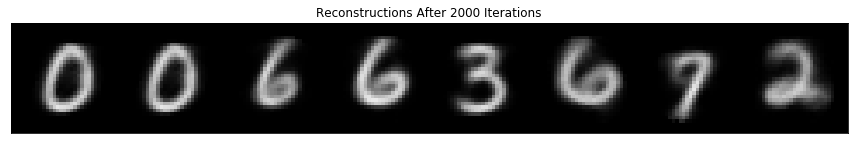

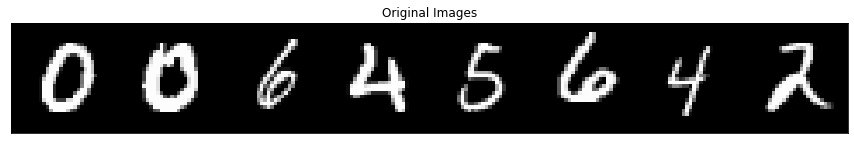

2100 iterations
recon_error: 0.044
perplexity: 24.298



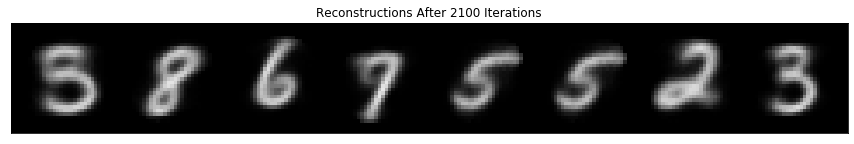

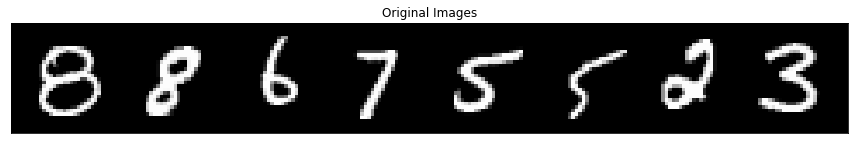

2200 iterations
recon_error: 0.044
perplexity: 25.026



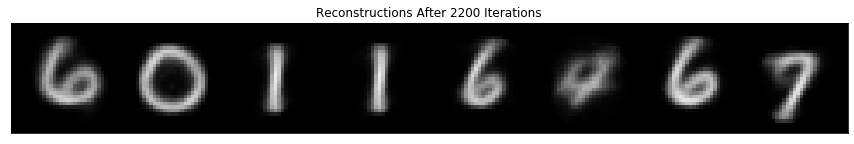

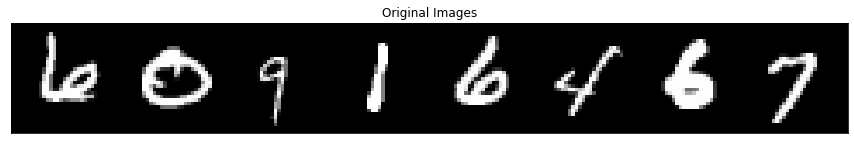

2300 iterations
recon_error: 0.044
perplexity: 25.110



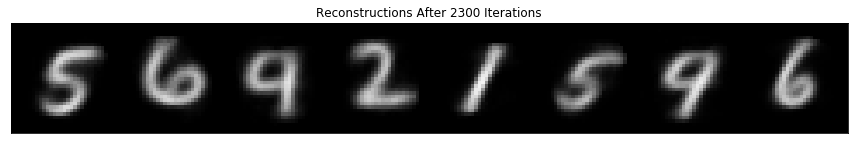

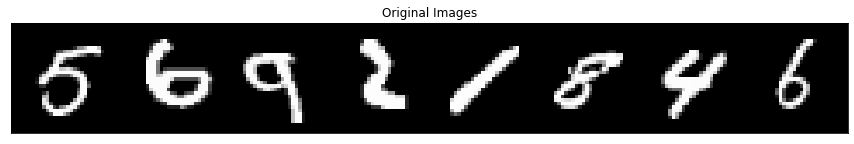

2400 iterations
recon_error: 0.044
perplexity: 25.438



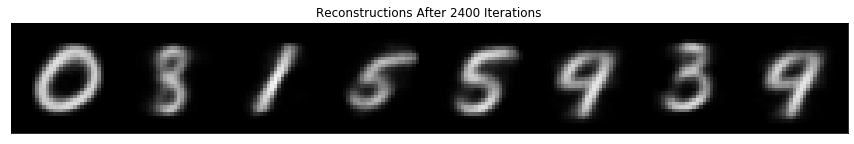

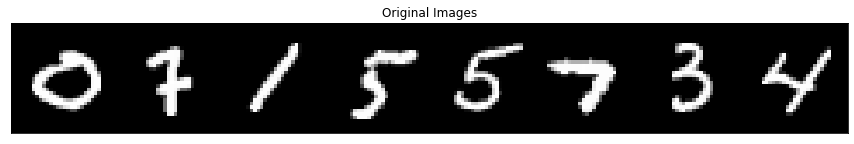

2500 iterations
recon_error: 0.044
perplexity: 25.787



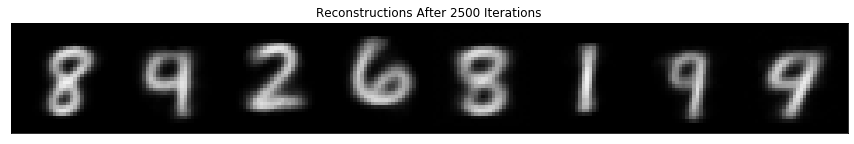

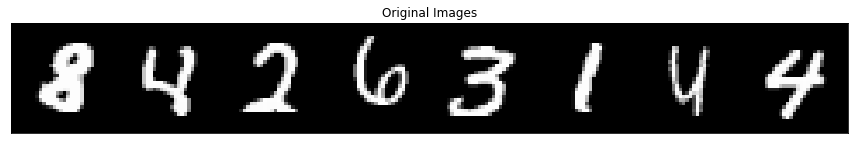

2600 iterations
recon_error: 0.044
perplexity: 25.639



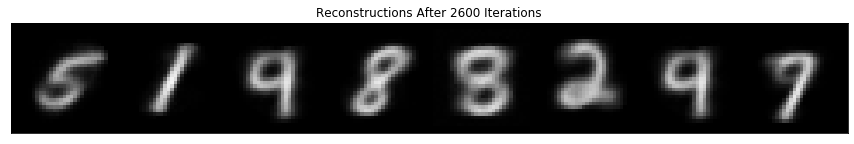

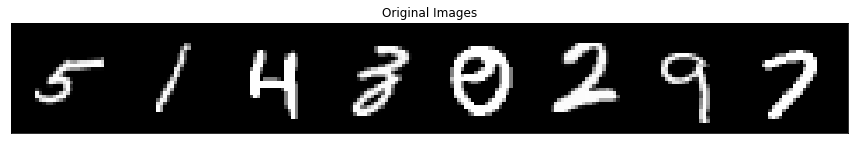

2700 iterations
recon_error: 0.043
perplexity: 25.482



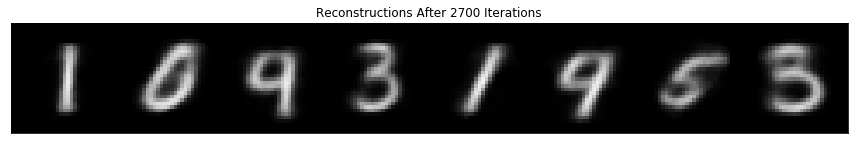

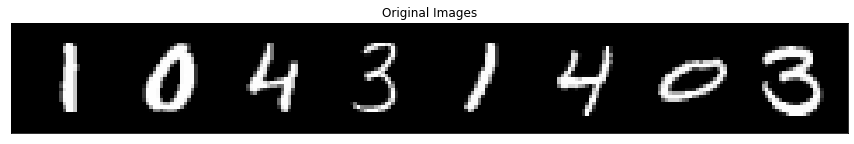

2800 iterations
recon_error: 0.043
perplexity: 25.810



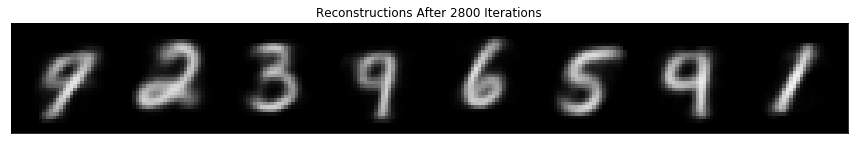

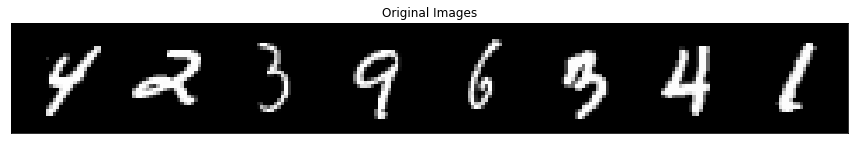

2900 iterations
recon_error: 0.043
perplexity: 25.875



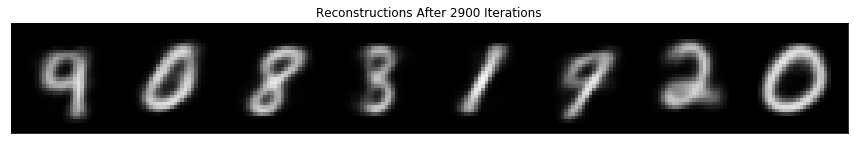

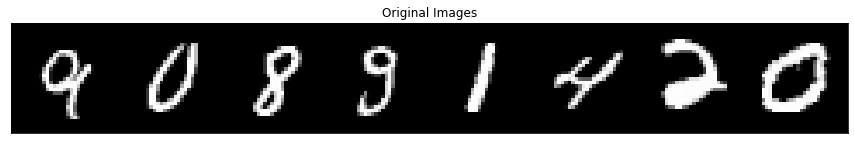

3000 iterations
recon_error: 0.043
perplexity: 25.881



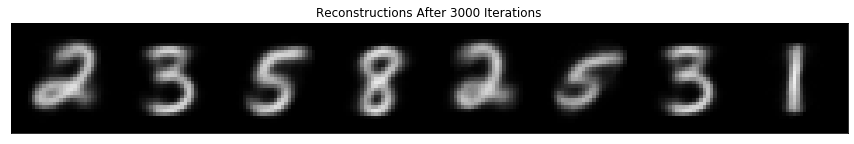

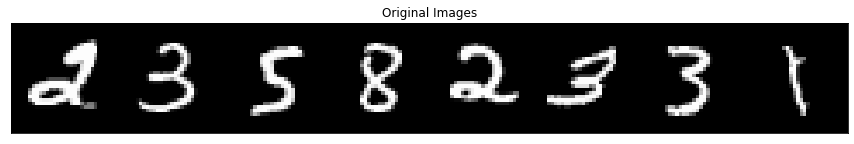

3100 iterations
recon_error: 0.043
perplexity: 25.836



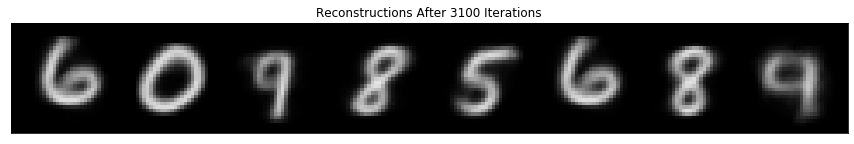

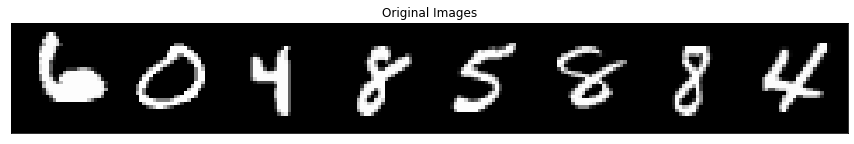

3200 iterations
recon_error: 0.043
perplexity: 25.930



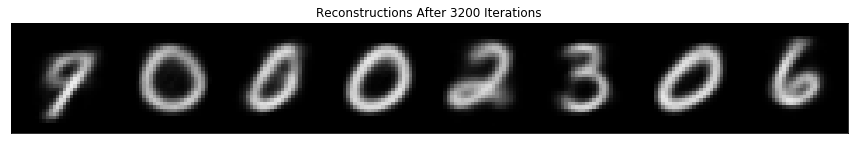

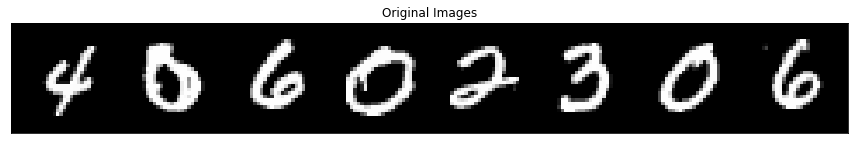

3300 iterations
recon_error: 0.043
perplexity: 26.127



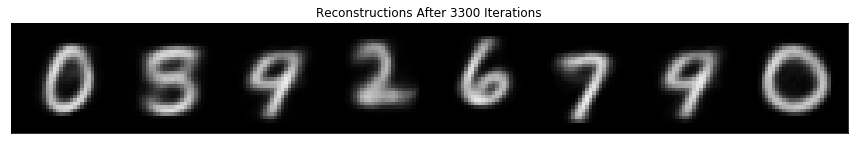

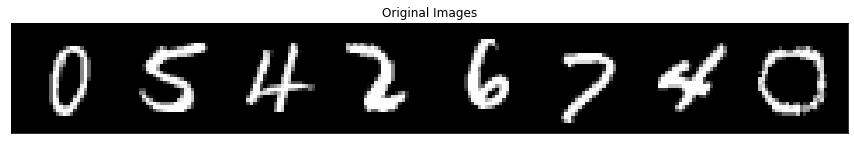

3400 iterations
recon_error: 0.043
perplexity: 25.939



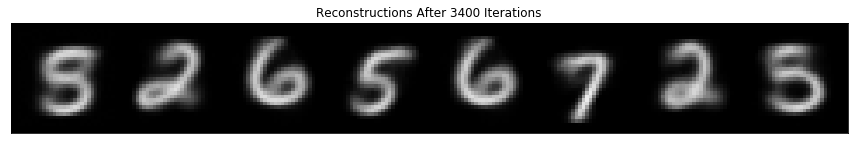

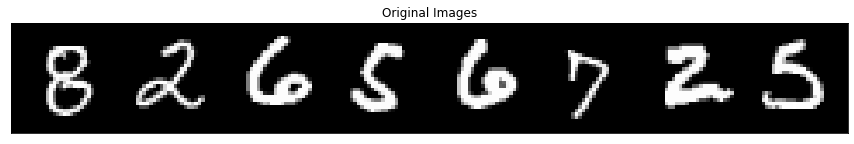

3500 iterations
recon_error: 0.043
perplexity: 26.005



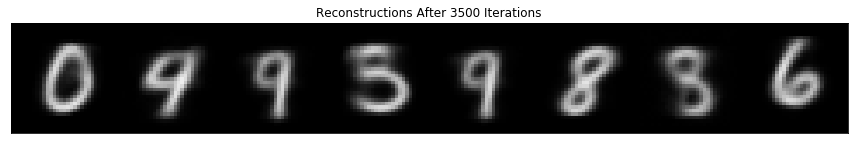

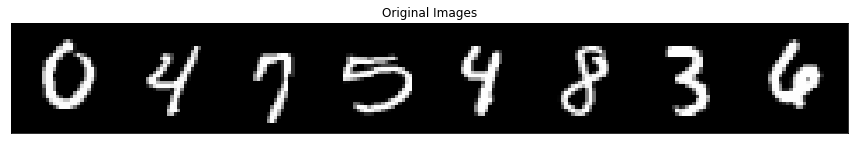

3600 iterations
recon_error: 0.043
perplexity: 26.095



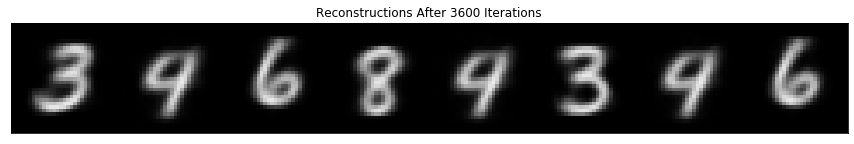

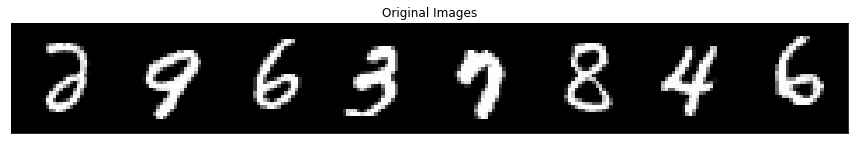

3700 iterations
recon_error: 0.043
perplexity: 26.137



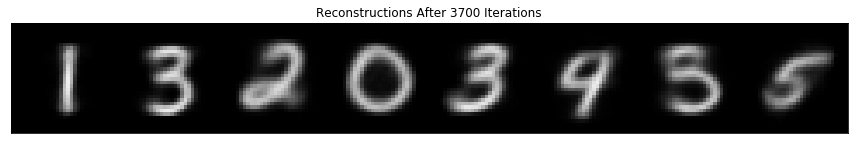

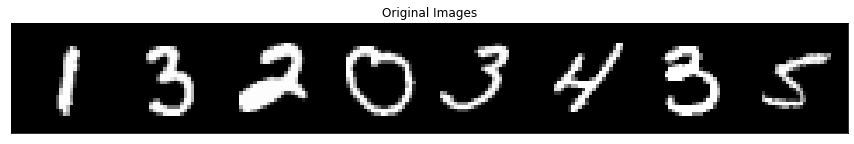

3800 iterations
recon_error: 0.043
perplexity: 26.520



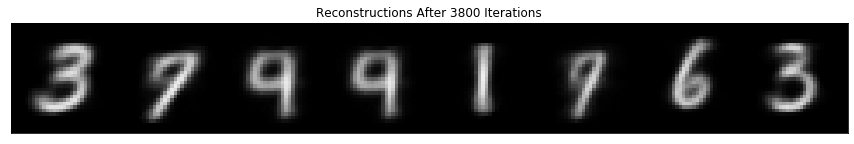

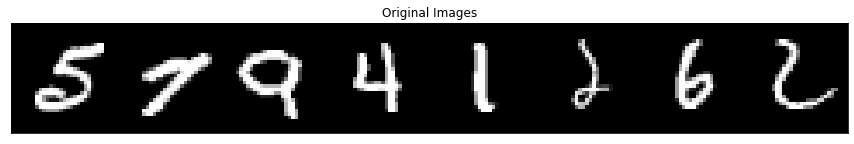

3900 iterations
recon_error: 0.043
perplexity: 26.299



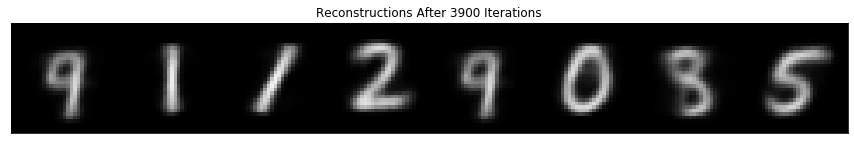

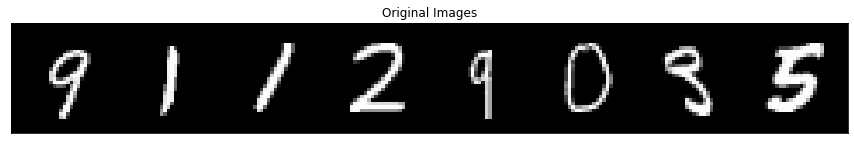

4000 iterations
recon_error: 0.043
perplexity: 26.413



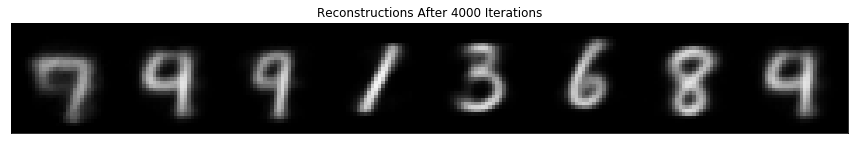

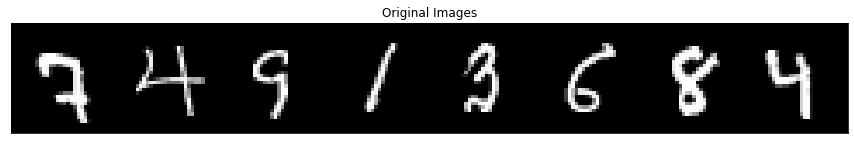

4100 iterations
recon_error: 0.043
perplexity: 26.499



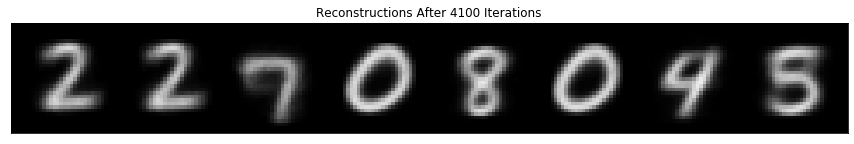

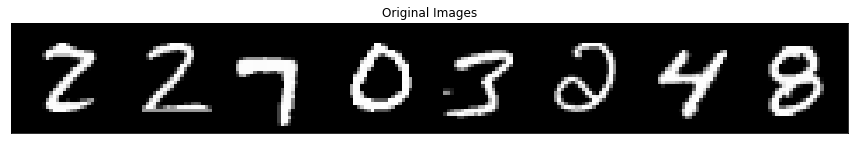

4200 iterations
recon_error: 0.043
perplexity: 26.602



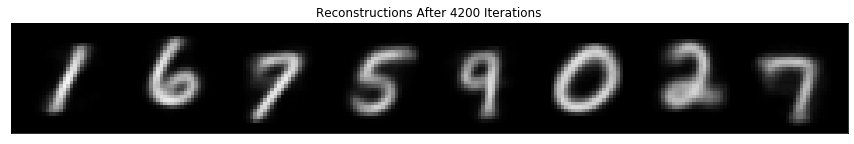

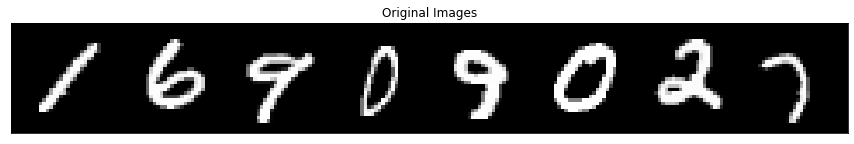

4300 iterations
recon_error: 0.043
perplexity: 26.486



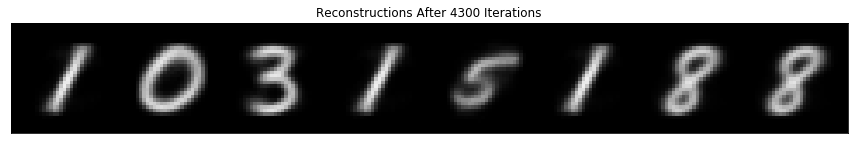

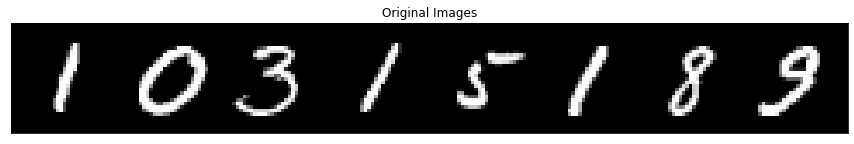

4400 iterations
recon_error: 0.043
perplexity: 26.363



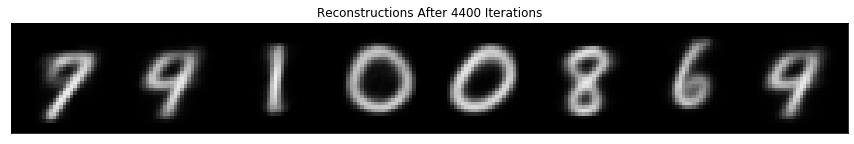

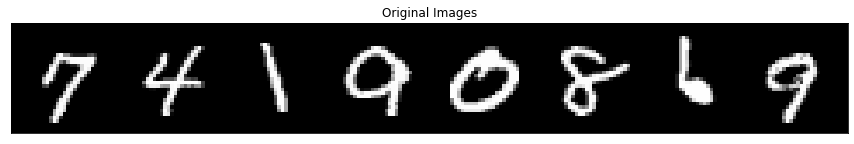

4500 iterations
recon_error: 0.043
perplexity: 26.307



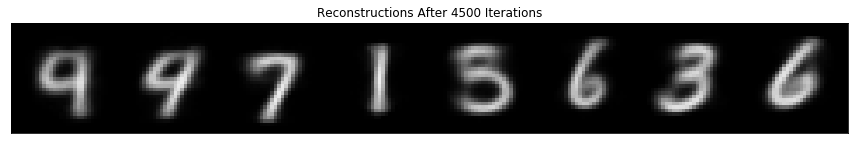

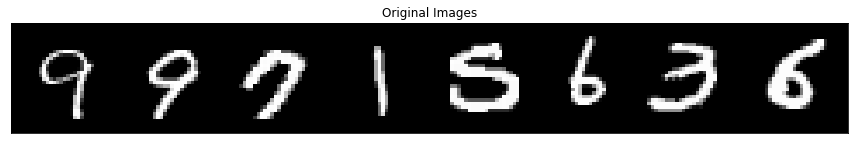

4600 iterations
recon_error: 0.043
perplexity: 26.527



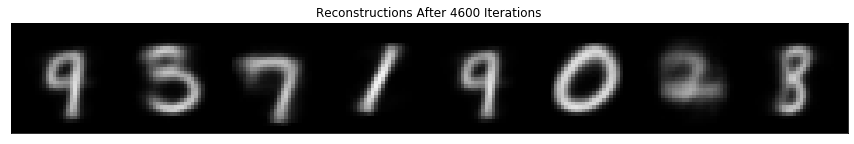

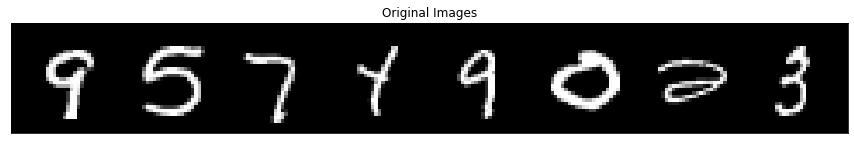

4700 iterations
recon_error: 0.043
perplexity: 26.446



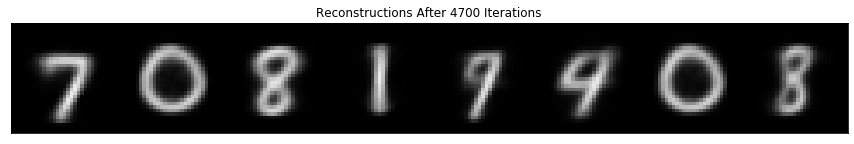

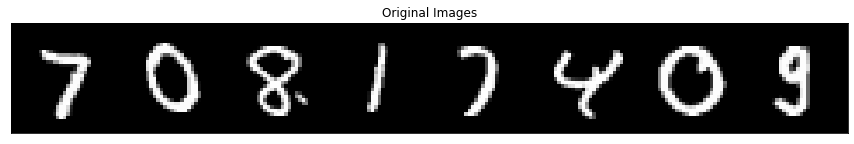

4800 iterations
recon_error: 0.043
perplexity: 26.638



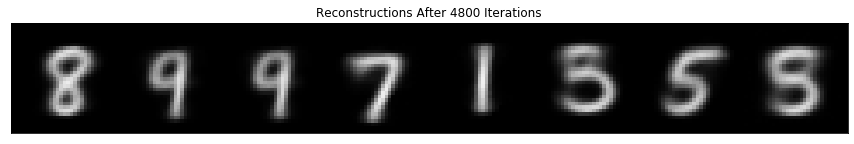

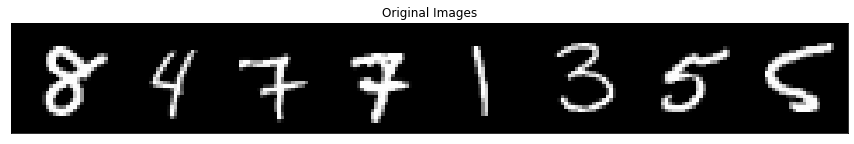

4900 iterations
recon_error: 0.043
perplexity: 26.541



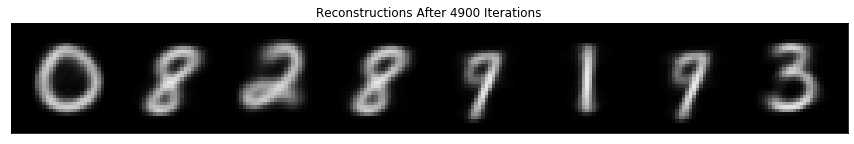

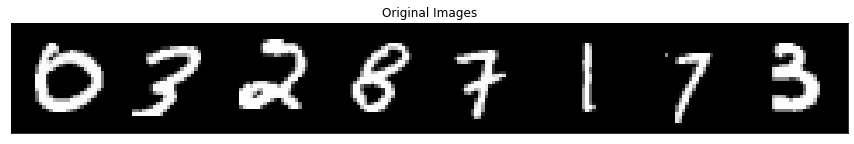

5000 iterations
recon_error: 0.043
perplexity: 26.537



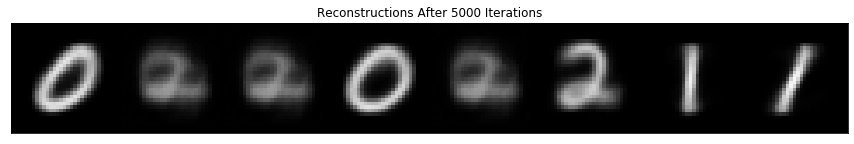

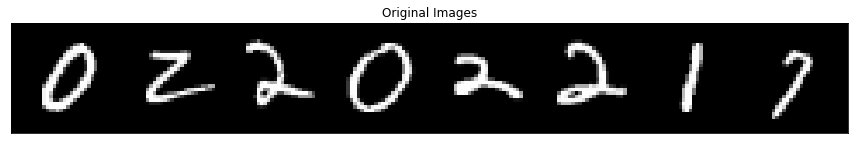

5100 iterations
recon_error: 0.043
perplexity: 26.686



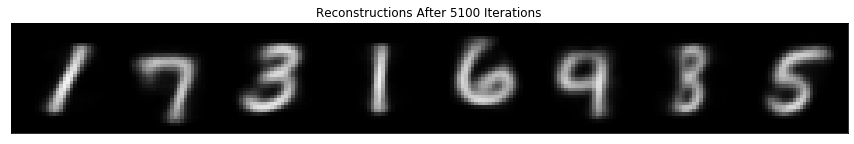

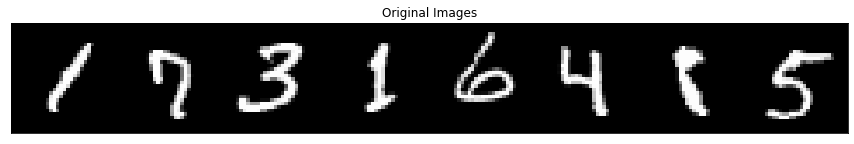

5200 iterations
recon_error: 0.043
perplexity: 26.593



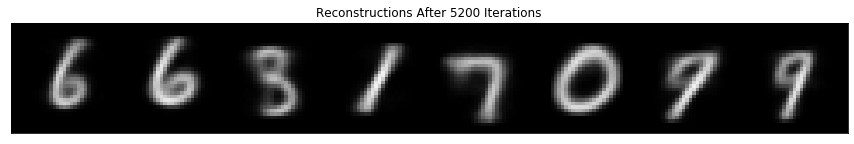

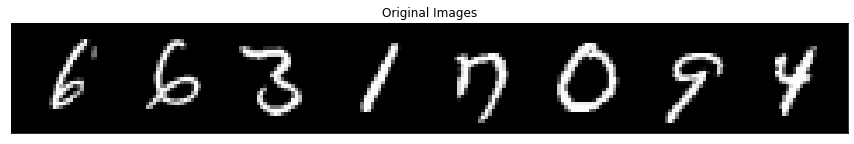

5300 iterations
recon_error: 0.043
perplexity: 26.720



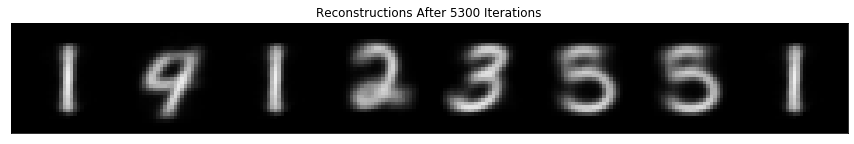

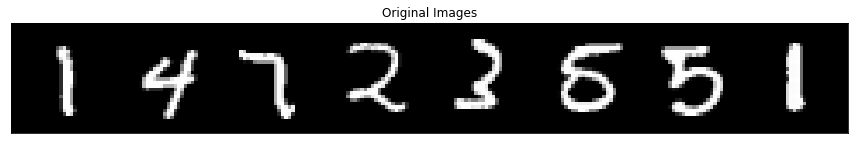

5400 iterations
recon_error: 0.043
perplexity: 26.372



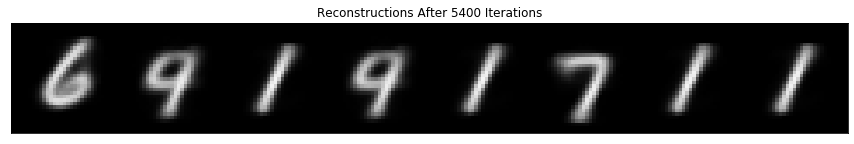

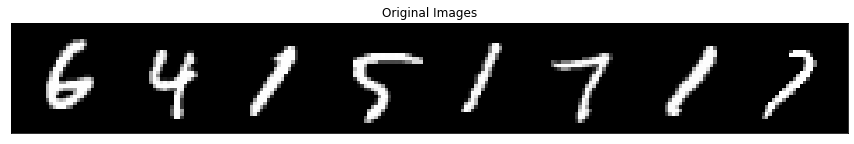

5500 iterations
recon_error: 0.043
perplexity: 26.476



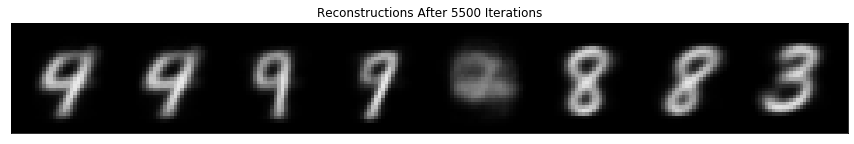

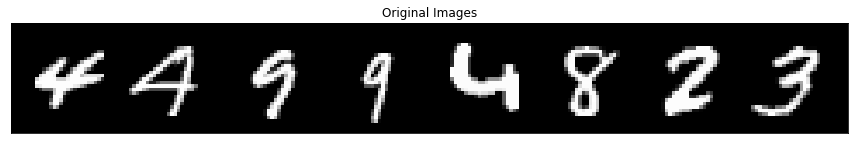

5600 iterations
recon_error: 0.043
perplexity: 26.646



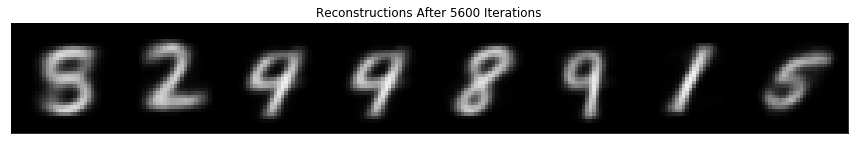

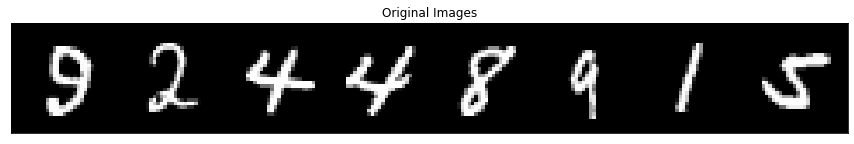

5700 iterations
recon_error: 0.043
perplexity: 26.429



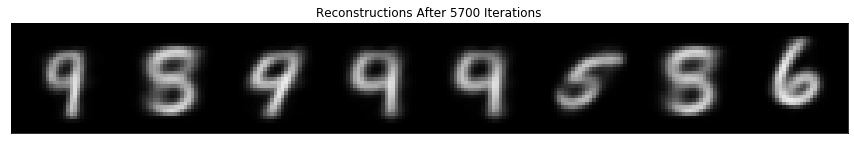

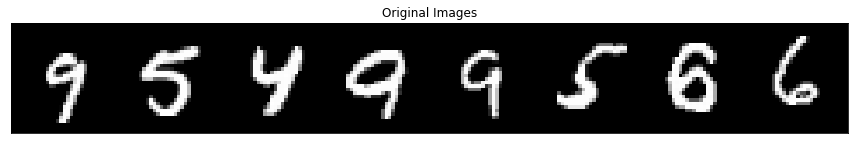

5800 iterations
recon_error: 0.043
perplexity: 26.710



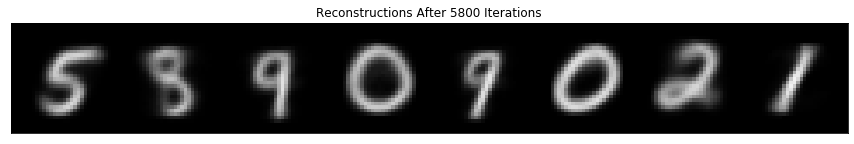

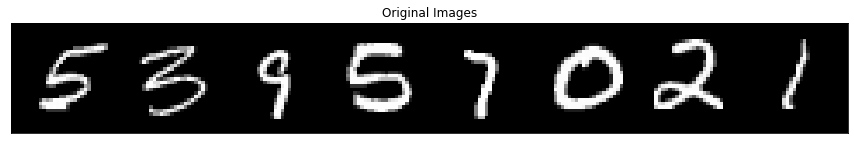

5900 iterations
recon_error: 0.043
perplexity: 26.638



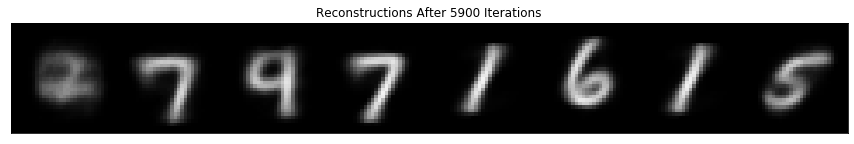

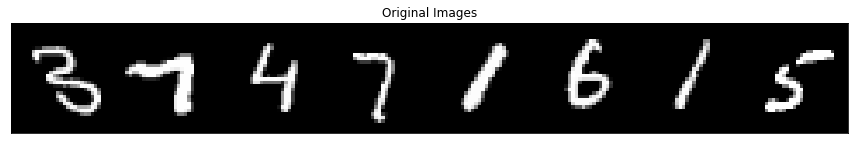

6000 iterations
recon_error: 0.043
perplexity: 26.687



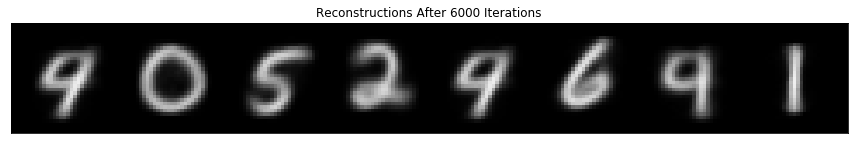

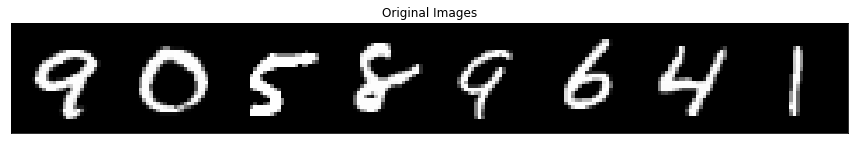

6100 iterations
recon_error: 0.043
perplexity: 26.661



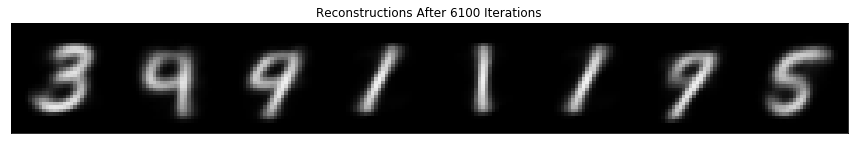

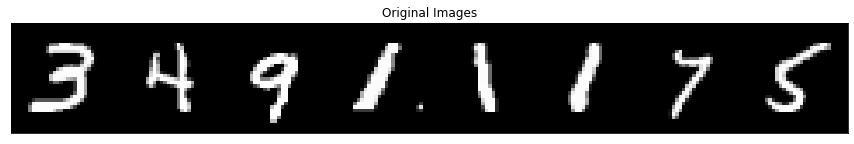

6200 iterations
recon_error: 0.043
perplexity: 26.515



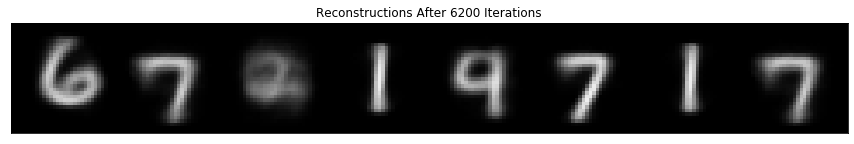

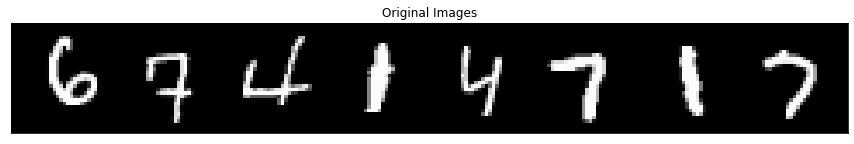

6300 iterations
recon_error: 0.043
perplexity: 26.517



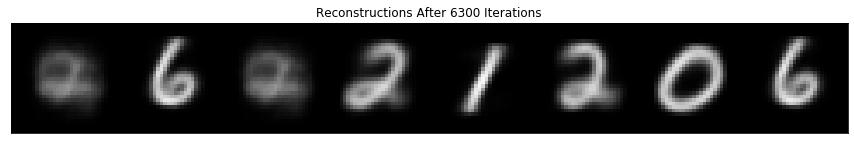

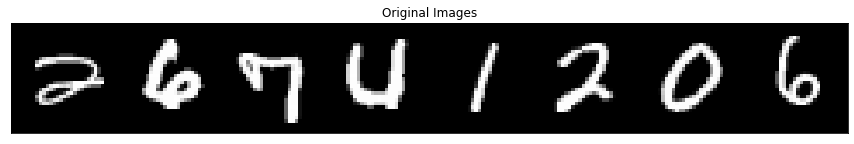

6400 iterations
recon_error: 0.043
perplexity: 26.391



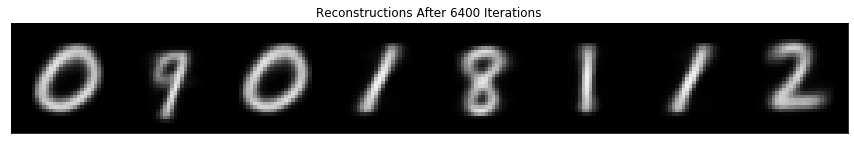

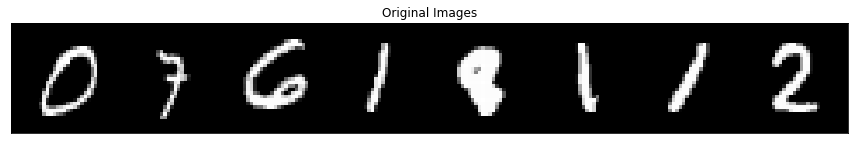

6500 iterations
recon_error: 0.043
perplexity: 26.415



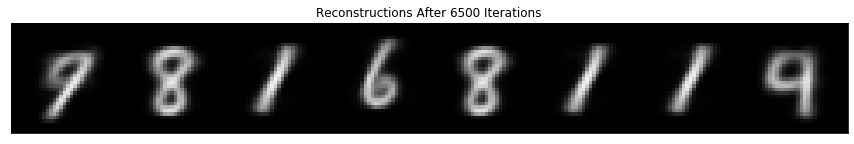

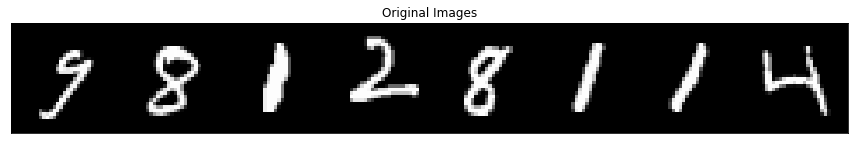

6600 iterations
recon_error: 0.043
perplexity: 26.507



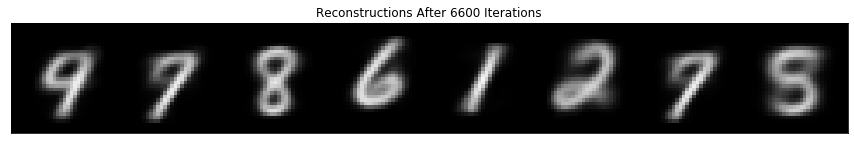

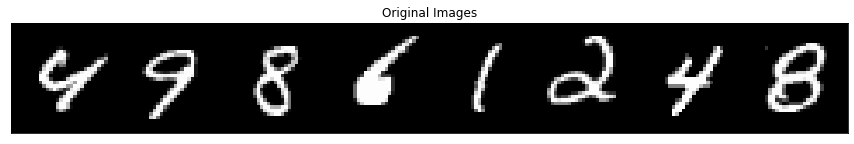

6700 iterations
recon_error: 0.043
perplexity: 26.494



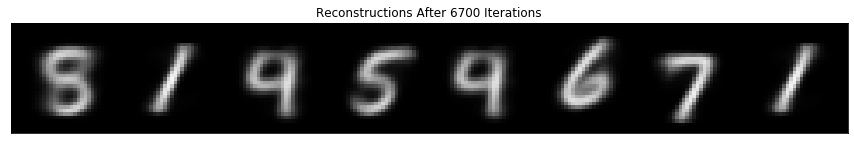

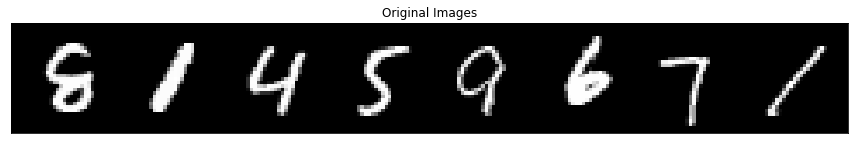

6800 iterations
recon_error: 0.043
perplexity: 26.421



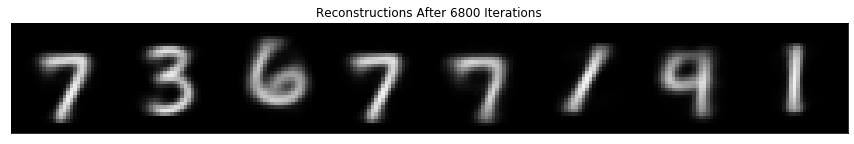

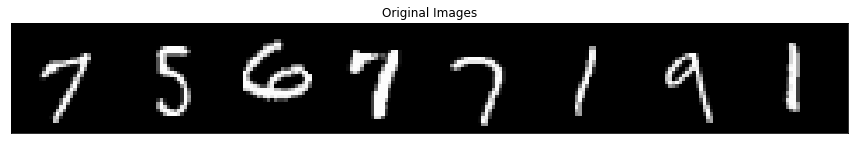

9600 iterations
recon_error: 0.043
perplexity: 26.822



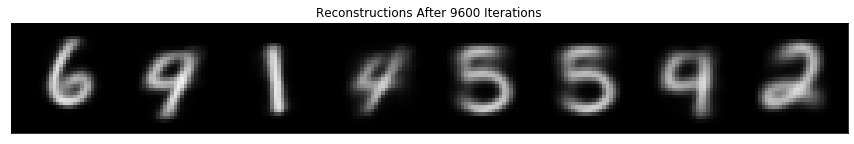

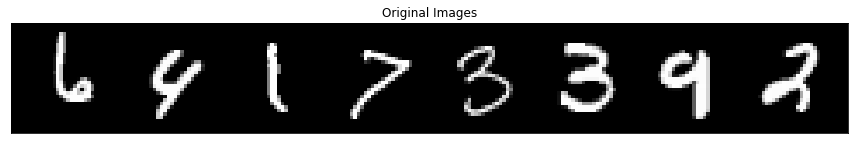

9700 iterations
recon_error: 0.043
perplexity: 26.725



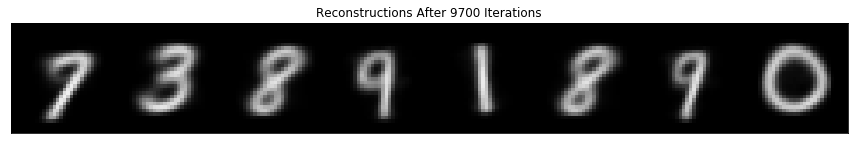

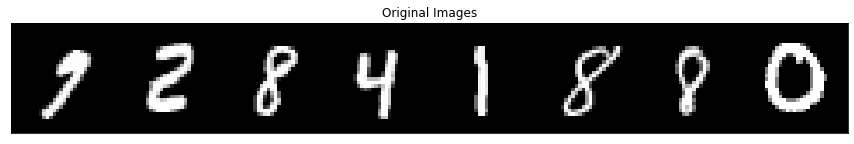

9800 iterations
recon_error: 0.043
perplexity: 26.687



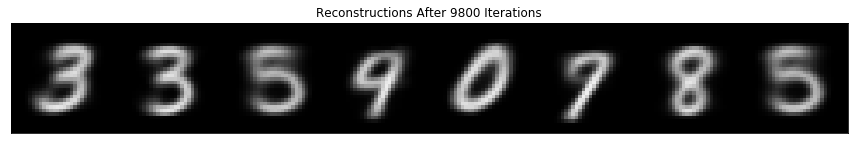

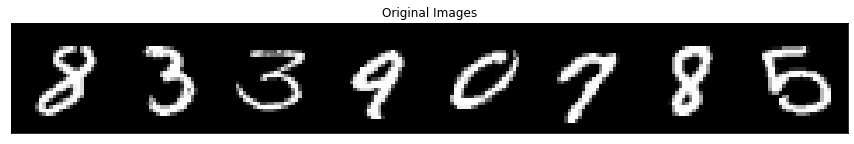

9900 iterations
recon_error: 0.043
perplexity: 26.538



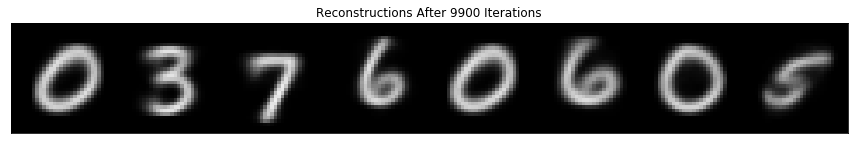

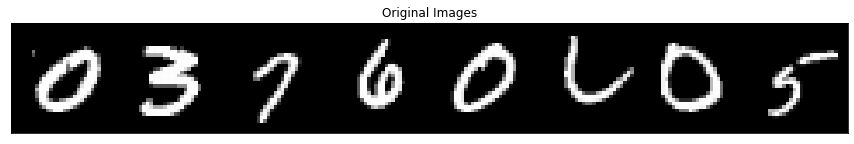

10000 iterations
recon_error: 0.043
perplexity: 26.809



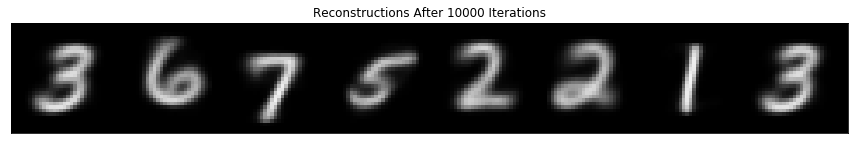

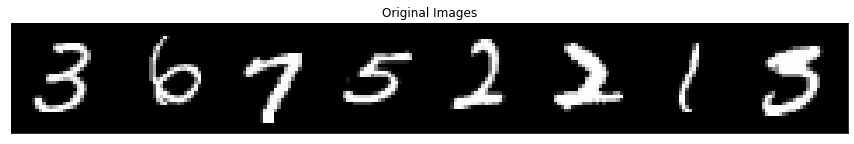

10100 iterations
recon_error: 0.043
perplexity: 26.777



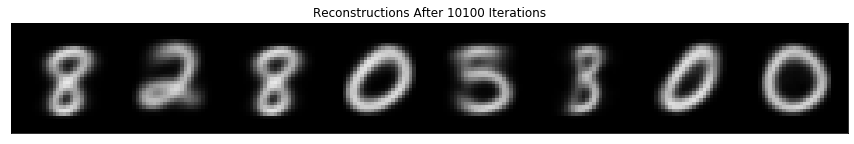

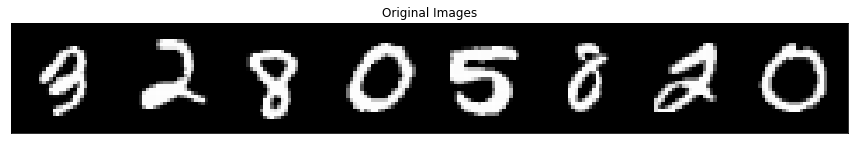

10200 iterations
recon_error: 0.043
perplexity: 26.750



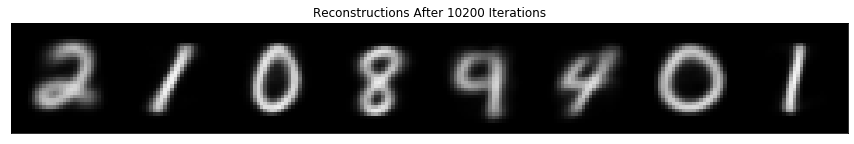

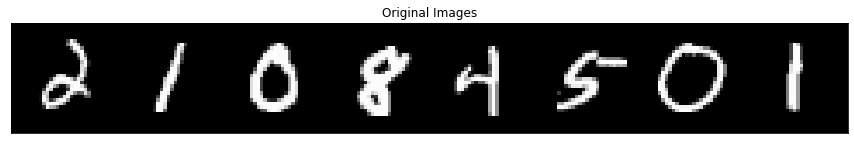

10300 iterations
recon_error: 0.043
perplexity: 26.396



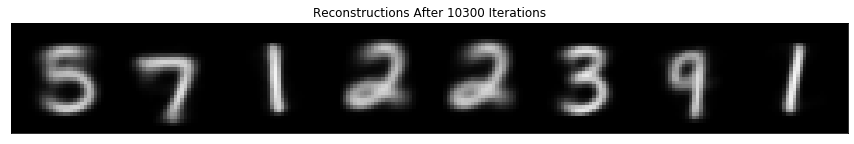

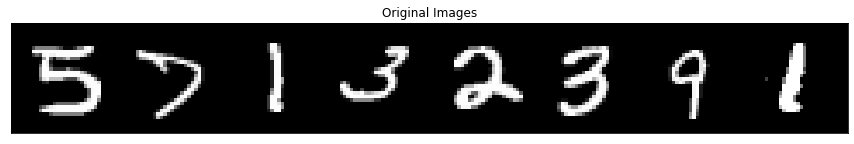

10400 iterations
recon_error: 0.043
perplexity: 26.434



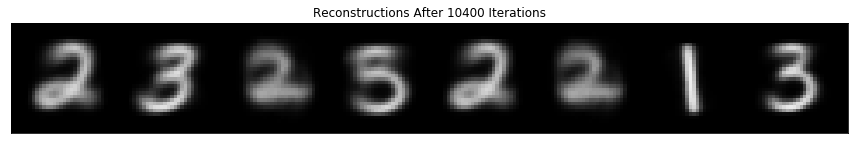

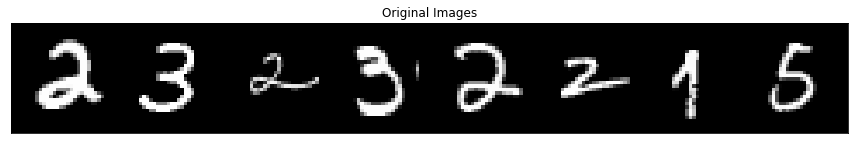

10500 iterations
recon_error: 0.043
perplexity: 26.756



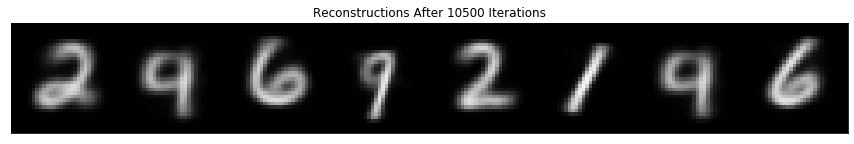

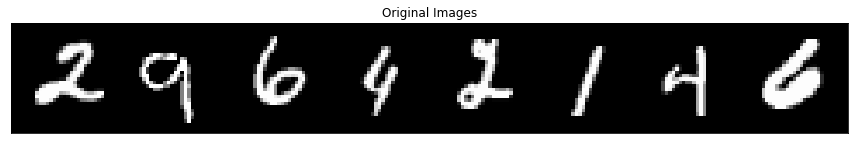

10600 iterations
recon_error: 0.043
perplexity: 26.524



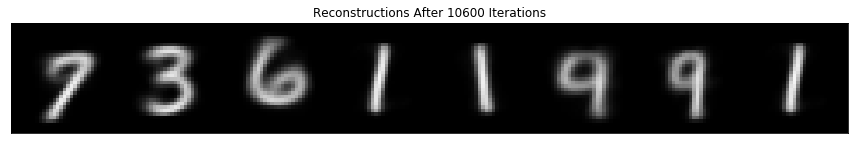

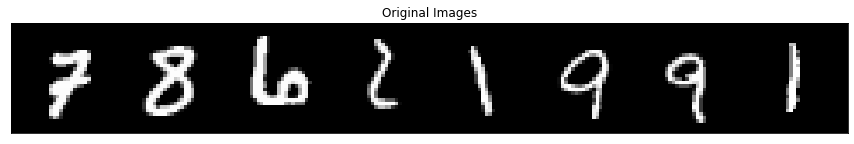

10700 iterations
recon_error: 0.043
perplexity: 26.546



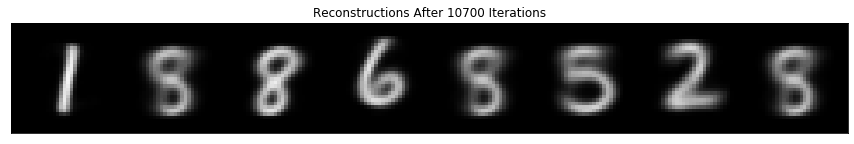

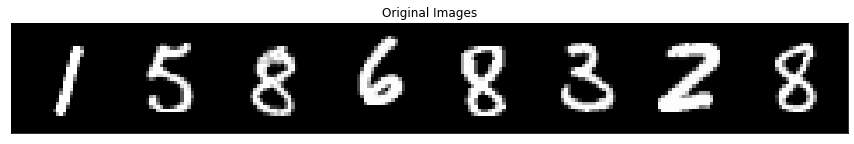

10800 iterations
recon_error: 0.043
perplexity: 26.483



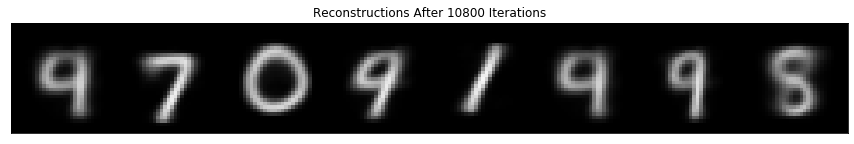

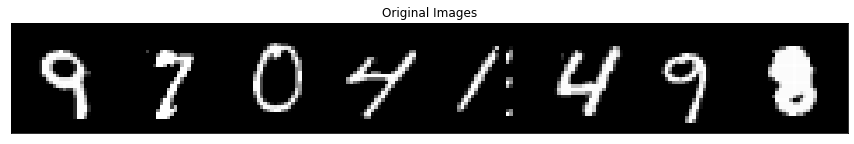

10900 iterations
recon_error: 0.043
perplexity: 26.497



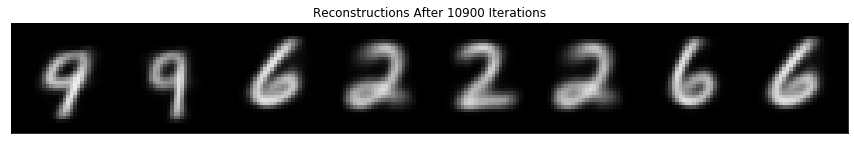

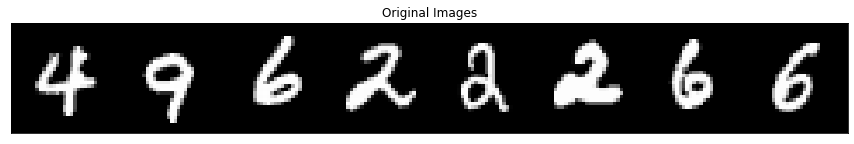

11000 iterations
recon_error: 0.043
perplexity: 26.373



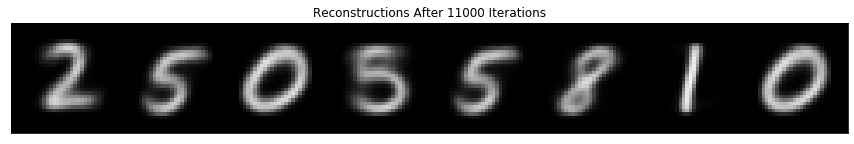

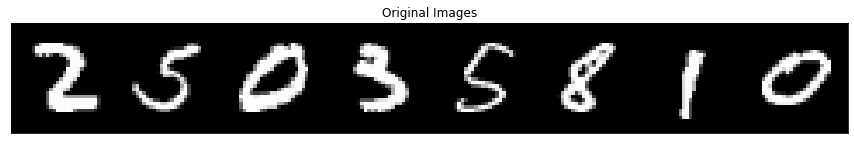

11100 iterations
recon_error: 0.043
perplexity: 26.448



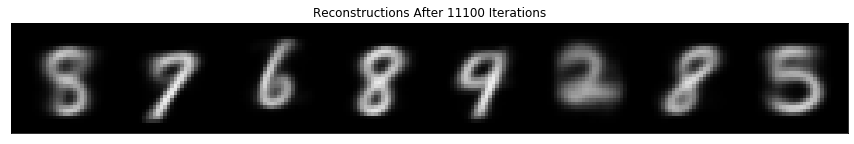

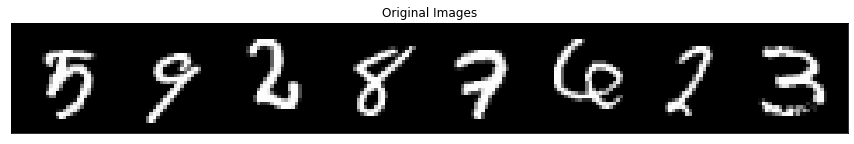

11200 iterations
recon_error: 0.043
perplexity: 26.289



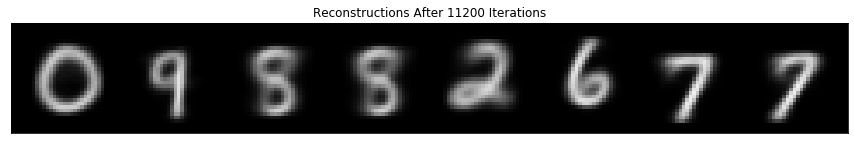

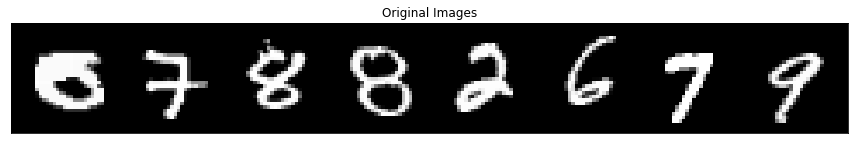

11300 iterations
recon_error: 0.043
perplexity: 26.171



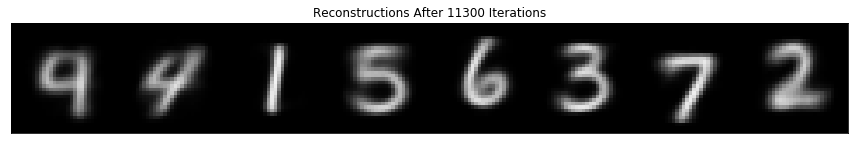

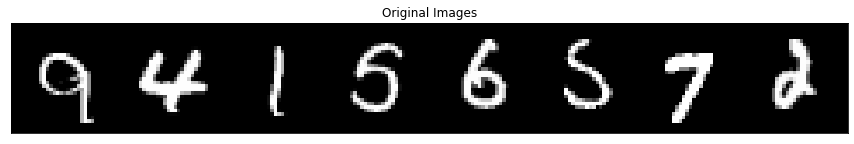

11400 iterations
recon_error: 0.043
perplexity: 26.575



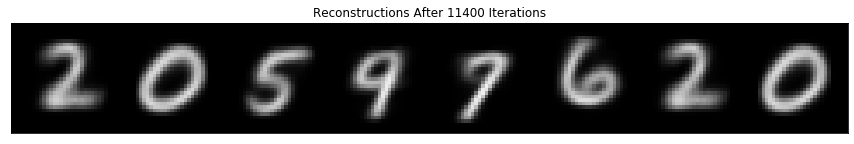

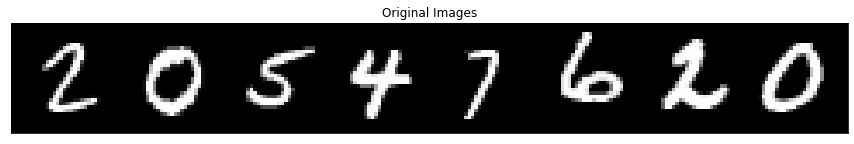

11500 iterations
recon_error: 0.043
perplexity: 26.515



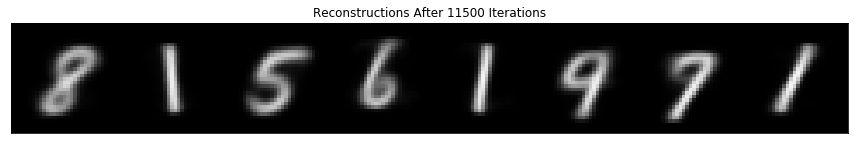

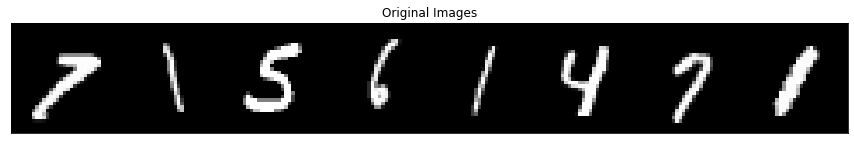

11600 iterations
recon_error: 0.043
perplexity: 26.373



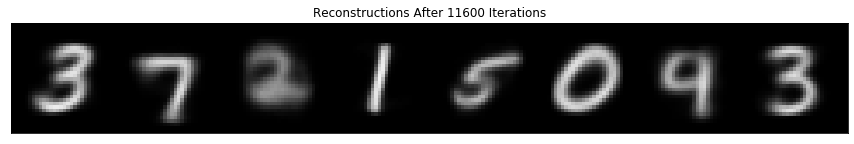

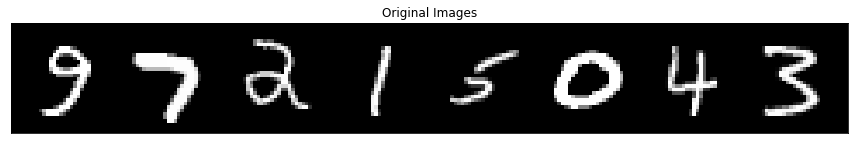

11700 iterations
recon_error: 0.043
perplexity: 26.452



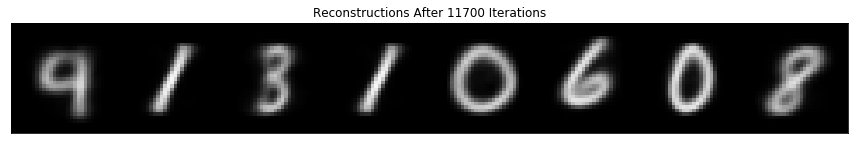

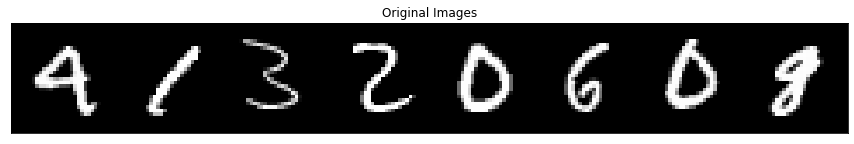

11800 iterations
recon_error: 0.043
perplexity: 26.203



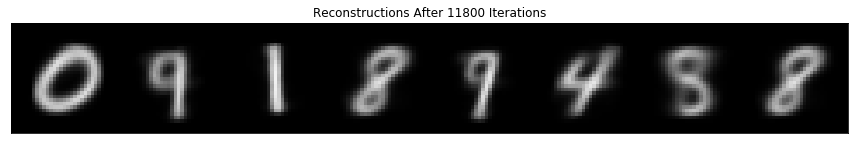

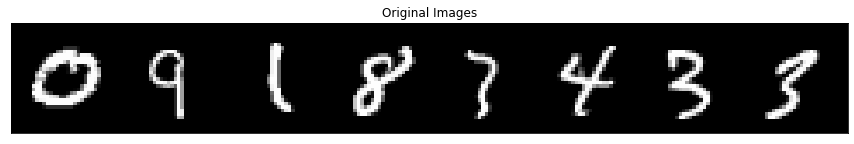

11900 iterations
recon_error: 0.043
perplexity: 26.638



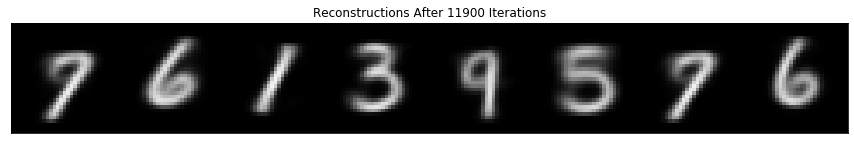

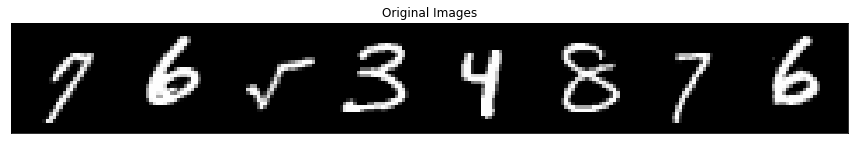

12000 iterations
recon_error: 0.043
perplexity: 26.345



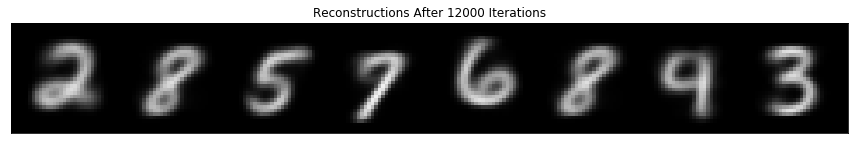

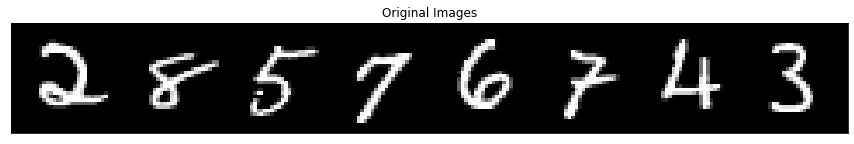

12100 iterations
recon_error: 0.044
perplexity: 26.281



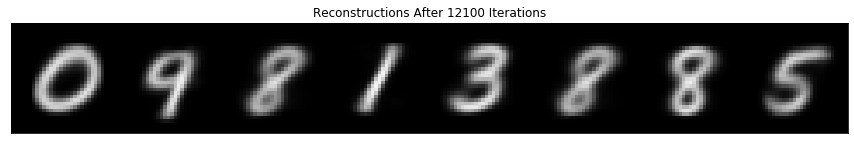

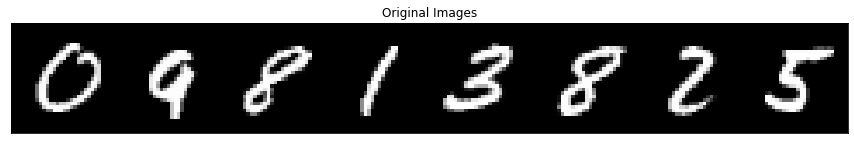

12200 iterations
recon_error: 0.043
perplexity: 26.538



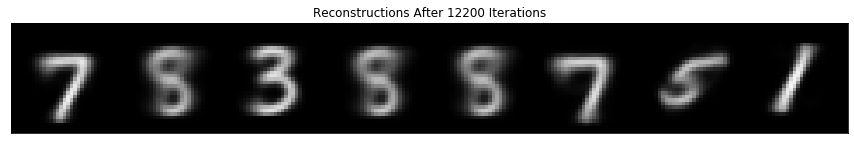

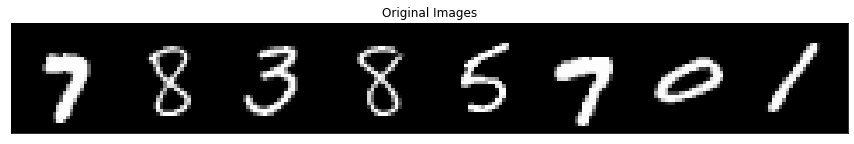

12300 iterations
recon_error: 0.043
perplexity: 26.129



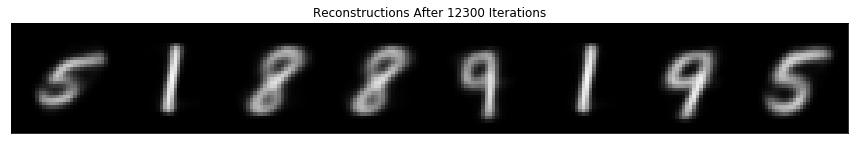

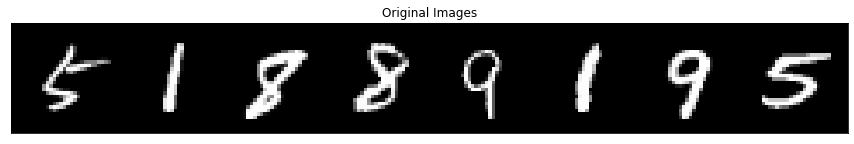

12400 iterations
recon_error: 0.043
perplexity: 26.347



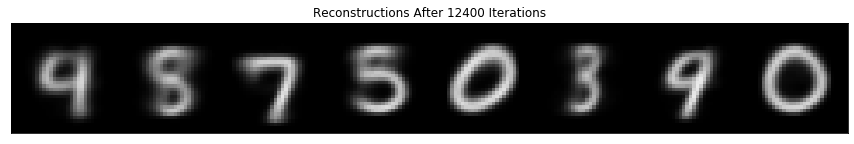

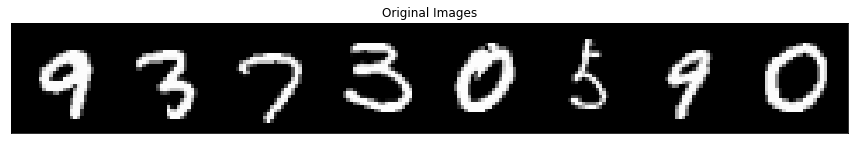

12500 iterations
recon_error: 0.043
perplexity: 26.338



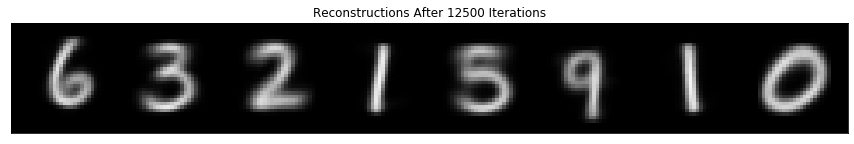

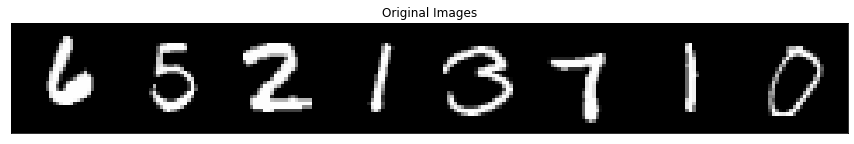

12600 iterations
recon_error: 0.043
perplexity: 26.281



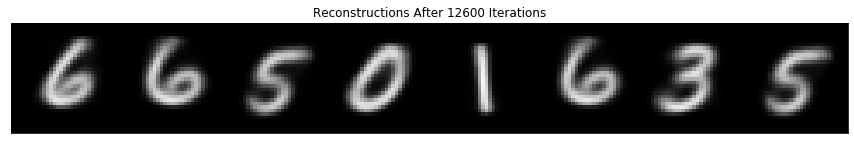

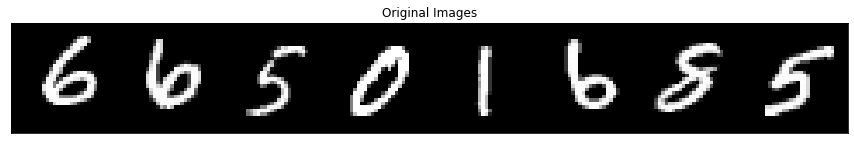

12700 iterations
recon_error: 0.043
perplexity: 26.386



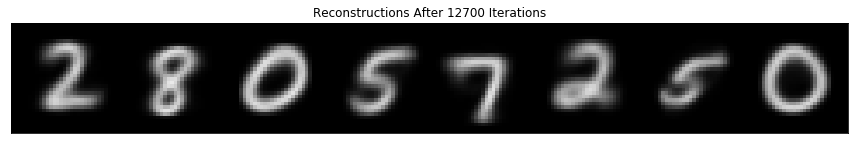

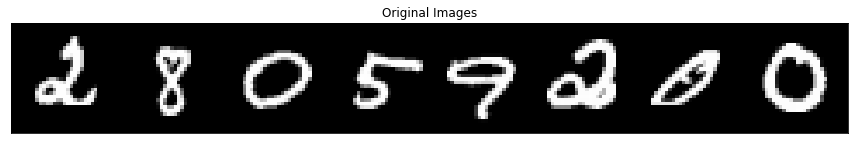

12800 iterations
recon_error: 0.043
perplexity: 26.117



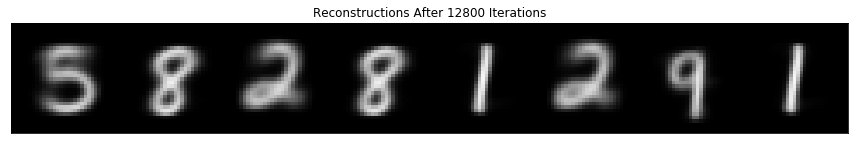

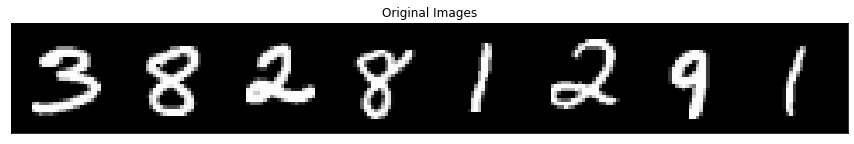

12900 iterations
recon_error: 0.043
perplexity: 26.300



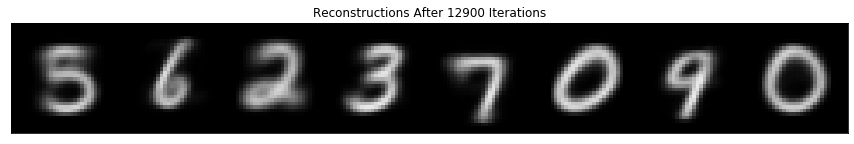

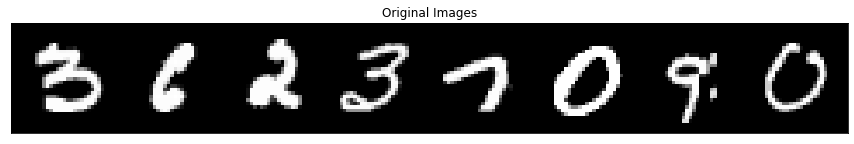

13000 iterations
recon_error: 0.043
perplexity: 25.926



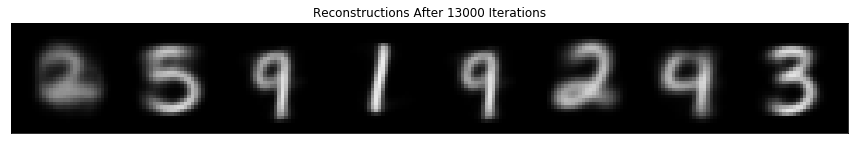

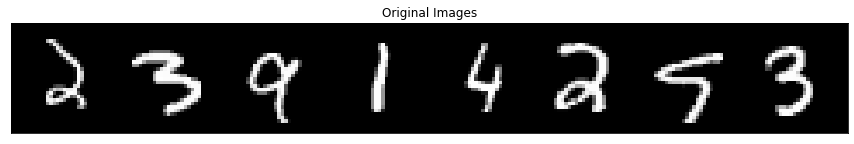

13100 iterations
recon_error: 0.043
perplexity: 26.136



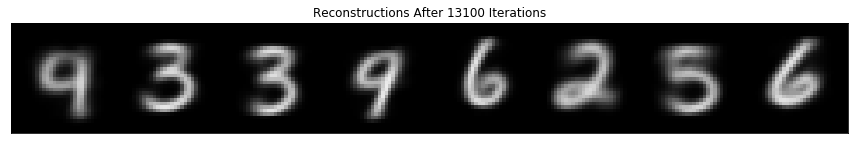

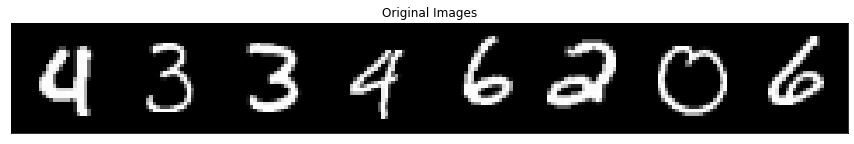

13200 iterations
recon_error: 0.043
perplexity: 26.224



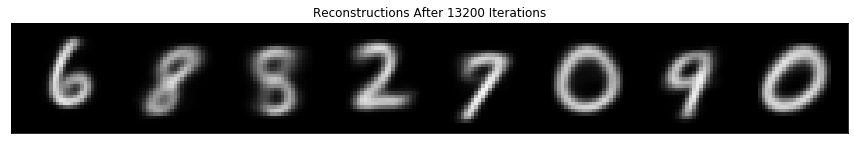

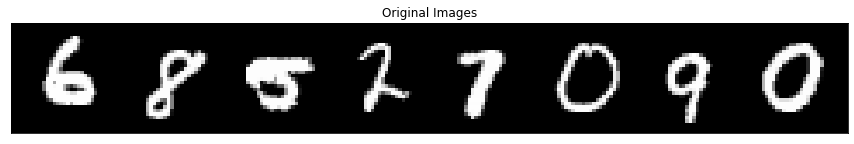

13300 iterations
recon_error: 0.043
perplexity: 26.105



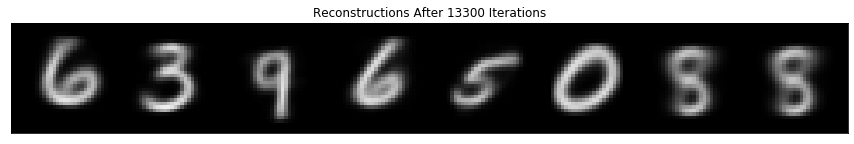

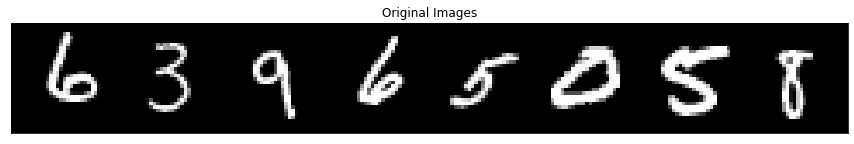

13400 iterations
recon_error: 0.043
perplexity: 26.035



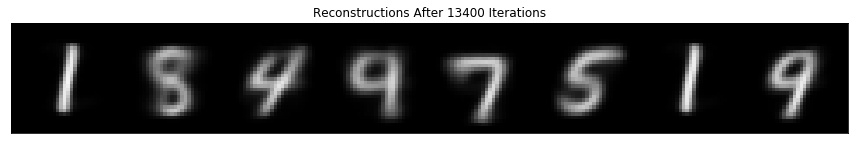

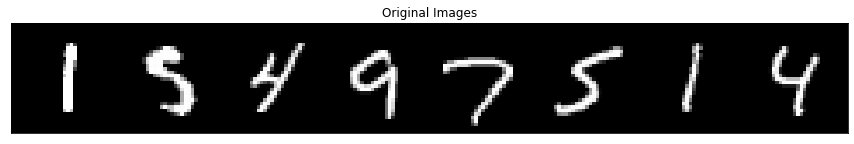

13500 iterations
recon_error: 0.043
perplexity: 26.243



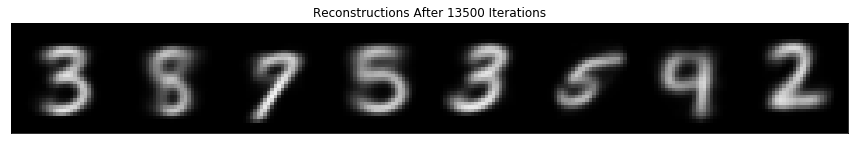

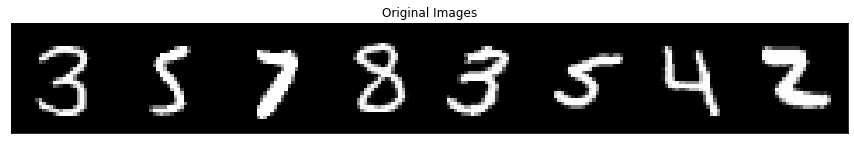

13600 iterations
recon_error: 0.044
perplexity: 26.216



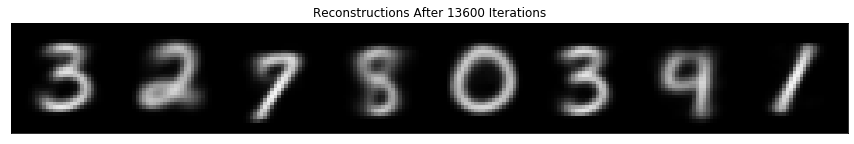

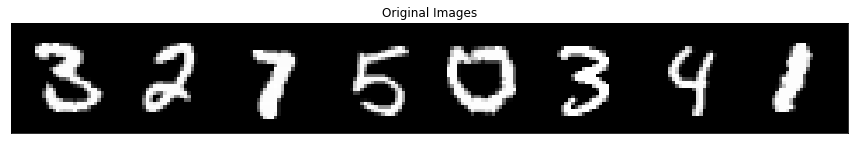

13700 iterations
recon_error: 0.043
perplexity: 26.132



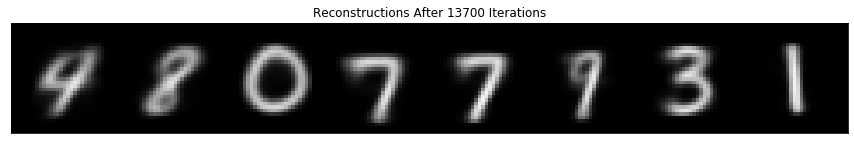

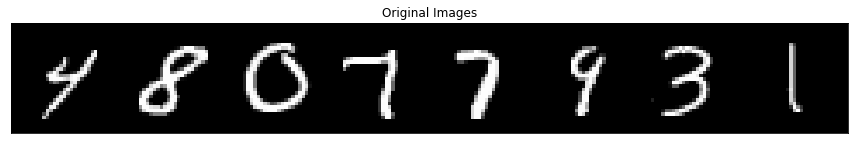

13800 iterations
recon_error: 0.044
perplexity: 26.083



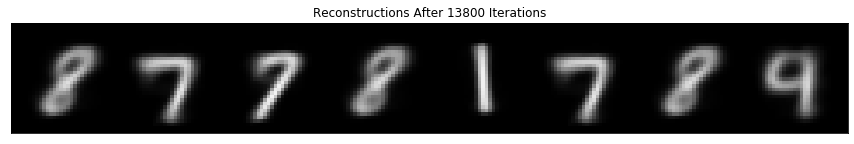

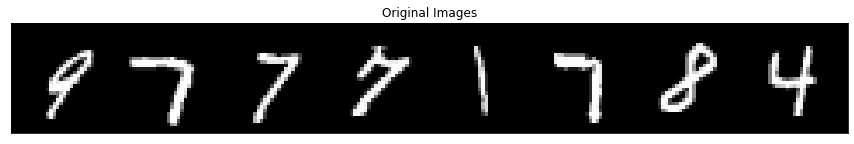

13900 iterations
recon_error: 0.043
perplexity: 26.206



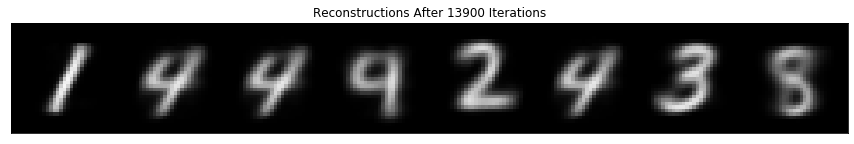

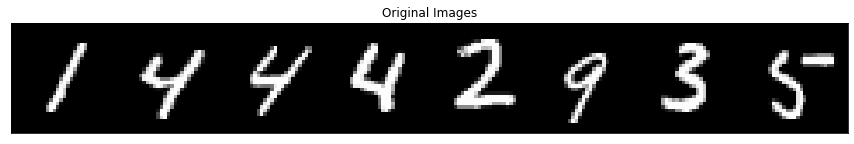

14000 iterations
recon_error: 0.043
perplexity: 26.212



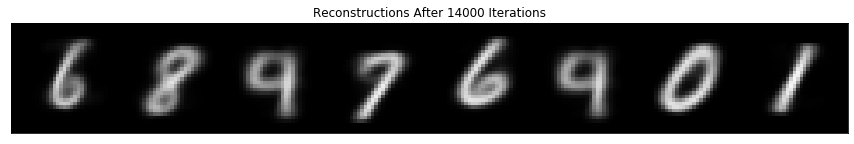

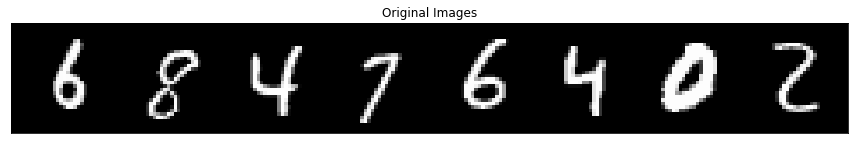

14100 iterations
recon_error: 0.043
perplexity: 26.307



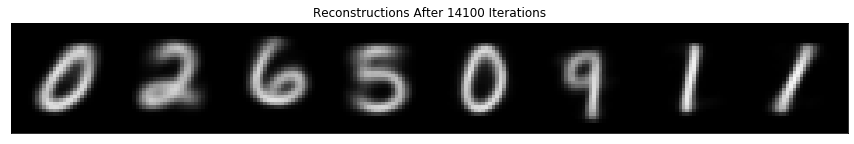

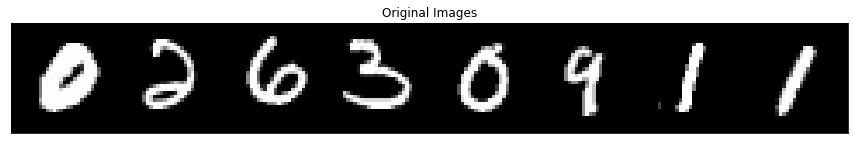

14200 iterations
recon_error: 0.043
perplexity: 26.207



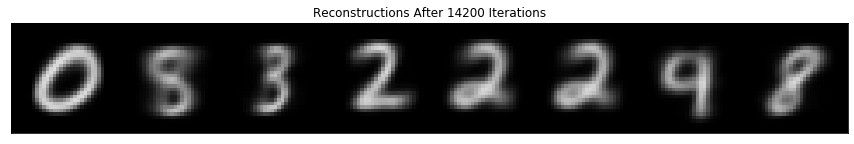

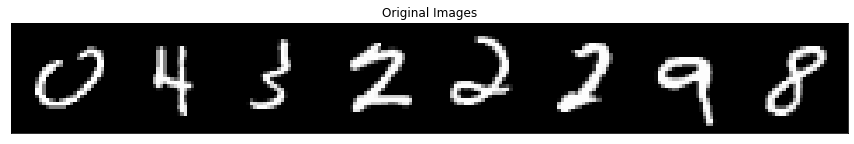

14300 iterations
recon_error: 0.044
perplexity: 26.023



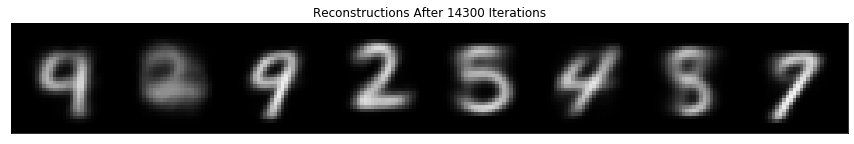

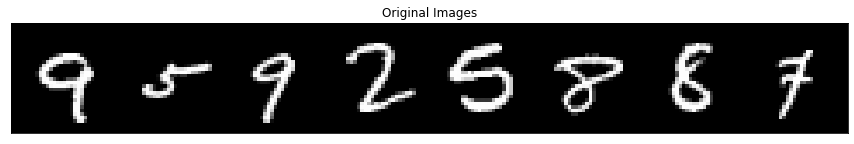

14400 iterations
recon_error: 0.043
perplexity: 25.991



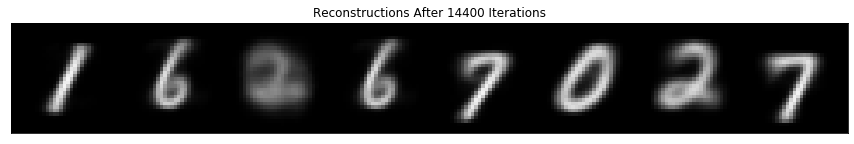

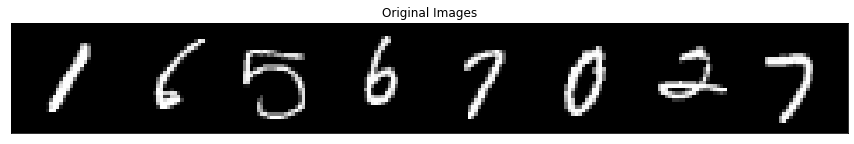

14500 iterations
recon_error: 0.043
perplexity: 25.747



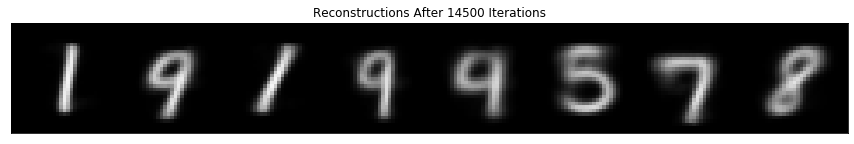

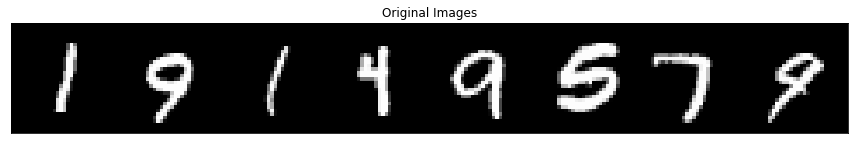

14600 iterations
recon_error: 0.043
perplexity: 26.047



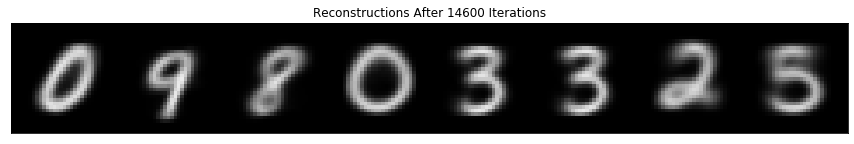

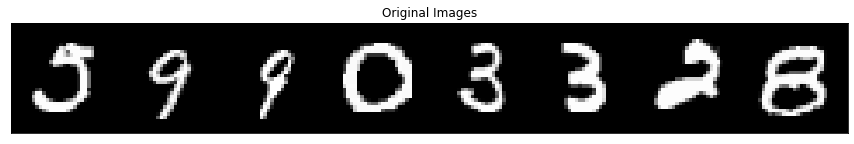

14700 iterations
recon_error: 0.043
perplexity: 25.540



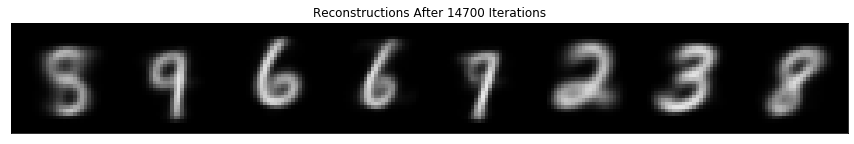

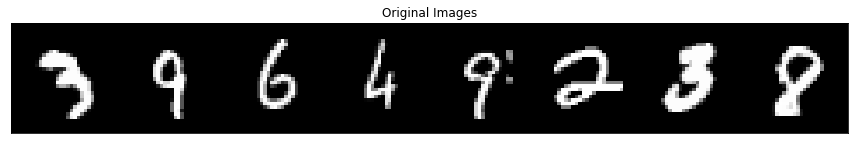

14800 iterations
recon_error: 0.044
perplexity: 25.882



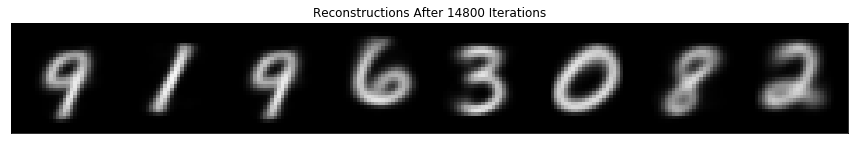

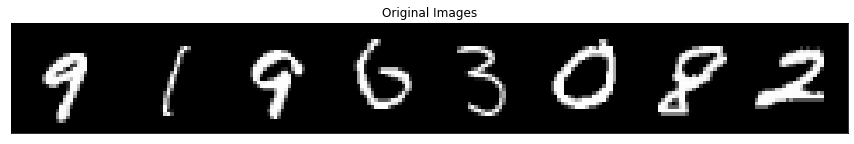

14900 iterations
recon_error: 0.043
perplexity: 25.932



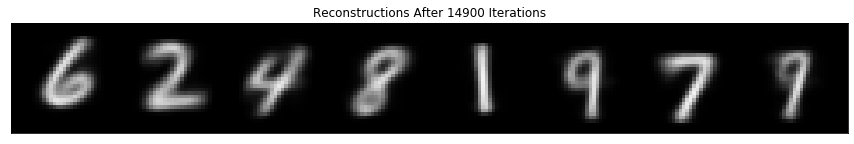

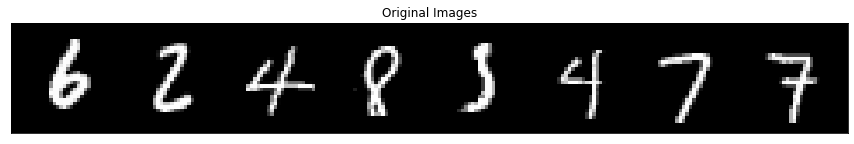

15000 iterations
recon_error: 0.043
perplexity: 25.865



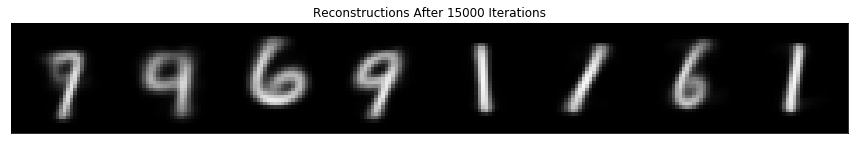

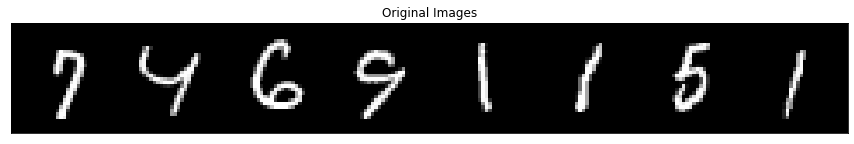

In [38]:
train_vq_vae(train_dl, vq_vae, num_training_updates, learning_rate)

### Decode Codebook Vectors

In [39]:
codebook_vectors = vq_vae.vq._embedding.weight

In [40]:
codebook_vectors_decoded = vq_vae.decode(codebook_vectors).detach().cpu()

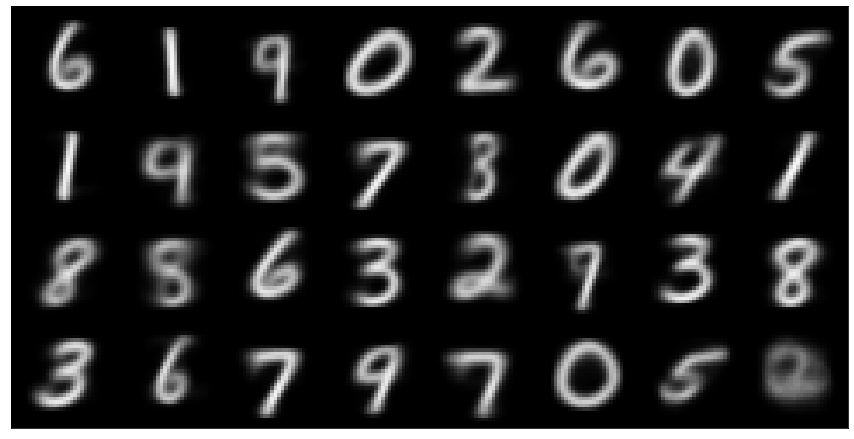

In [41]:
show_batch(codebook_vectors_decoded)

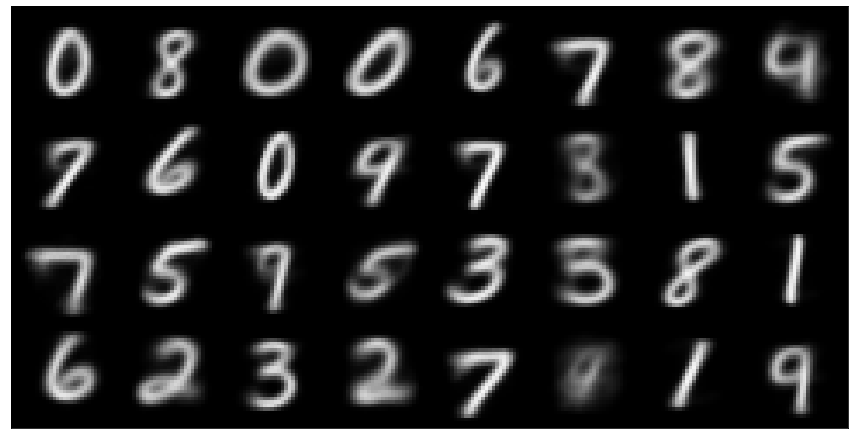

In [36]:
show_batch(codebook_vectors_decoded)

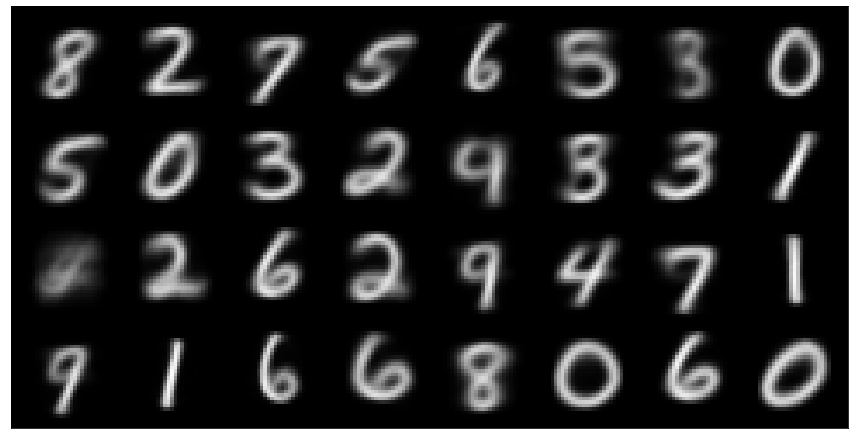

In [29]:
show_batch(codebook_vectors_decoded) #batch_size=, embeddings=10, commitment_cost=0.25

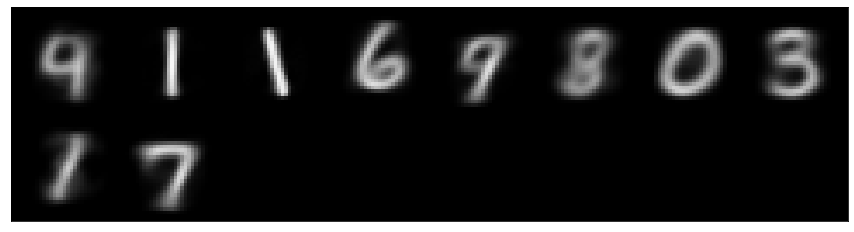

In [24]:
show_batch(codebook_vectors_decoded) #batch_size=2048, embeddings=10, commitment_cost=0.25